<a href="https://colab.research.google.com/github/theresaskruzna/riiid_knowledge_tracing/blob/chunksize_data/01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Riiid Answer Correctness Prediction

**Dataset Description**

---



https://www.kaggle.com/competitions/riiid-test-answer-prediction/data

Tailoring education to a student's ability level is one of the many valuable things an AI tutor can do. Your challenge in this competition is a version of that overall task; you will predict whether students are able to answer their next questions correctly. You'll be provided with the same sorts of information a complete education app would have: that student's historic performance, the performance of other students on the same question, metadata about the question itself, and more.

**Files**

*train.csv*

row_id: (int64) ID code for the row.

timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

user_id: (int32) ID code for the user.

content_id: (int16) ID code for the user interaction

content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

*questions.csv:* metadata for the questions posed to users.

question_id: foreign key for the train/test content_id column, when the content type is question (0).

bundle_id: code for which questions are served together.

correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

part: the relevant section of the TOEIC test.

tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

*lectures.csv:* metadata for the lectures watched by users as they progress in their education.

lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).

part: top level category code for the lecture.

tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

type_of: brief description of the core purpose of the lecture

# Import Libraries

In [1]:
!pip install -q kaggle # Instal the Kaggle API package (-q flag makes the installation "quiet")

from google.colab import files # file upload dialogue module

import kagglehub
import os
import pickle
import gc # garbage collector module
import time #

# Pre-processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Visualisations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Model building
import lightgbm as lgb
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, BatchNormalization, Embedding, Concatenate, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


# Predefine Functions

Check memory usage

In [2]:
def memory_usage(df):
    return f"{df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB"

Box plot (outliers)

In [3]:
def plot_boxplot(data, x=None, y=None, hue=None, color=None, title=None, horizontal=False):
    """
    Creates a customizable box plot.

    Parameters:
    - data: Pandas DataFrame containing the data.
    - x: Column name for the x-axis (categorical).
    - y: Column name for the y-axis (numeric).
    - hue: Optional column for additional grouping.
    - color: Optional color for the boxes.
    - title: Optional title for the plot.
    - horizontal: Boolean to plot horizontally (default is vertical).
    """

    # Set orientation
    orient = 'h' if horizontal else 'v'

    plt.figure(figsize=(5, 5)) # Create a 'canvas' to draw the plot onto
    # plt.figure(figsize=figsize) - alternate code if parameter given in function call
    sns.boxplot(data=data, x=x, y=y, hue=hue, orient=orient) # Create the boxplot

    # Custom labels and title
    if horizontal:
        plt.xlabel(y)  # In horizontal orientation, y values are on x-axis
        plt.ylabel(x)  # In horizontal orientation, x values are on y-axis
    else:
        plt.xlabel(x)
        plt.ylabel(y)
        # In vertical orientation, x values are on x-axis, y values are on y-axis
    if title:
        plt.title(title) # add title to plot if provided in function call

    # Handle label rotation for vertical plots with many categories
    if orient == 'v' and x is not None:
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout() # adjusts the plot padding to ensure all labels fit within the figure without being cut off
    plt.show() # display plot

# Example usage:
# plot_boxplot(df, x='category', y='value')                  # Basic vertical boxplot
# plot_boxplot(df, x='value', y='category', orient='h')      # Horizontal boxplot
# plot_boxplot(df, x='category', y='value', hue='group')     # Grouped boxplot

    # additional parameters
    # xlabel=None, ylabel=None, figsize=(8, 5), orient='v', showfliers=True, palette=None
    """
    Parameters:
    - color: Optional color for the boxes.
    - xlabel: Optional x-axis label.
    - ylabel: Optional y-axis label.
    - figsize: Tuple defining the figure size (default=(8,5)).
    - orient: Orientation of the plot ('v' for vertical, 'h' for horizontal).
    - showfliers: Whether to show outlier points (default=True).
    - palette: Color palette for groups when hue is specified.
    """

Box plot with sampling

In [ ]:
def plot_boxplot(data, x=None, y=None, hue=None, color=None, title=None, horizontal=False):
    """
    Creates a customizable box plot.

    Parameters:
    - data: Pandas DataFrame containing the data.
    - x: Column name for the x-axis (categorical).
    - y: Column name for the y-axis (numeric).
    - hue: Optional column for additional grouping.
    - color: Optional color for the boxes.
    - title: Optional title for the plot.
    - horizontal: Boolean to plot horizontally (default is vertical).
    """

    sample_size = 100000  # Define sample size here
    # Sample the data if it's larger than the sample size
    if len(data) > sample_size:
        data = data.sample(n=sample_size)  # Random sampling without replacement

    # Set orientation
    orient = 'h' if horizontal else 'v'

    plt.figure(figsize=(5, 5)) # Create a 'canvas' to draw the plot onto
    # plt.figure(figsize=figsize) - alternate code if parameter given in function call
    sns.boxplot(data=data, x=x, y=y, hue=hue, orient=orient) # Create the boxplot

    # Custom labels and title
    if horizontal:
        plt.xlabel(y)  # In horizontal orientation, y values are on x-axis
        plt.ylabel(x)  # In horizontal orientation, x values are on y-axis
    else:
        plt.xlabel(x)
        plt.ylabel(y)
        # In vertical orientation, x values are on x-axis, y values are on y-axis
    if title:
        plt.title(title) # add title to plot if provided in function call

    # Handle label rotation for vertical plots with many categories
    if orient == 'v' and x is not None:
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout() # adjusts the plot padding to ensure all labels fit within the figure without being cut off
    plt.show() # display plot

# Example usage:
# plot_boxplot(df, x='category', y='value')                  # Basic vertical boxplot
# plot_boxplot(df, x='value', y='category', orient='h')      # Horizontal boxplot
# plot_boxplot(df, x='category', y='value', hue='group')     # Grouped boxplot

    # additional parameters
    # xlabel=None, ylabel=None, figsize=(8, 5), orient='v', showfliers=True, palette=None
    """
    Parameters:
    - color: Optional color for the boxes.
    - xlabel: Optional x-axis label.
    - ylabel: Optional y-axis label.
    - figsize: Tuple defining the figure size (default=(8,5)).
    - orient: Orientation of the plot ('v' for vertical, 'h' for horizontal).
    - showfliers: Whether to show outlier points (default=True).
    - palette: Color palette for groups when hue is specified.
    """

KDE plot

In [4]:
def plot_kde(data, column, hue=None, title=None):
    """
    Creates a simple KDE plot for a specified column.

    Parameters:
    - data: Pandas DataFrame
    - column: Column name to plot
    - hue: Optional categorical column for grouping
    - title: Optional plot title
    """

    plt.figure(figsize=(8, 5)) # Create a 'canvas' to draw the plot onto
    # plt.figure(figsize=figsize) - alternate code if parameter given in function call

    # Sample large datasets for better performance
    if len(data) > 250000 and hue is None:
        # Create a sampled version of data for very large datasets
        sampled_data = data.iloc[::250000]
        sns.kdeplot(data=sampled_data, x=column, fill=True) # create KDE plot
    else:
        # Use the full dataset for normal-sized data or when using hue
        sns.kdeplot(data=data, x=column, hue=hue, fill=True) # create KDE plot
        # df, column, split into categories if provided, fill area under line with colour

    # Custom labels and title
    plt.xlabel(column) # horizontal line label
    # plt.xlabel(xlabel if xlabel else column) - alternate code to add label
    plt.ylabel("Density") # vertical line label
    if title:
        plt.title(title) # add title to plot if provided in function call

    plt.show() # display plot

    # --- Added code for descriptive statistics ---
    # Assume 'column' is numerical by default
    categorical = False

    # Check if the column is of object (string) type, which often represents categorical data
    if data[column].dtype == 'object':
        categorical = True

    if categorical:
        values = data[column].value_counts().values
    else:
        # Apply sampling for large datasets here too
        if len(data) > 250000:
            values = data[column].values[::250000]
        else:
            values = data[column].values

    print('Mean: {:,}'.format(np.mean(values)))
    print('Median: {:,}'.format(np.median(values)))
    print('Max: {:,}'.format(np.max(values)))
    # --- End of added code ---

# Example usage:
# plot_kde(df, 'column_name', hue='category_column', title='KDE Plot')

# additional parameters:
# bw_adjust=1, color=None, xlabel=None, ylabel="Density", figsize=(8, 5)
    """
    Parameters:
    - bw_adjust: Bandwidth adjustment factor (default=1).
    - color: Optional color for the KDE curve.
    - xlabel: Optional x-axis label.
    - ylabel: Y-axis label (default="Density").
    - figsize: Tuple defining the figure size (default=(8,5)).
    """

Bar plot

In [5]:
def plot_bar(data, x, y=None, hue=None, color=None, title=None, rotate_labels=True):
    """
    Creates a customizable bar plot.

    Parameters:
    - data: Pandas DataFrame containing the data.
    - x: Column name for the x-axis categories.
    - y: Optional column name for the y-axis values (if None, counts are used).
    - hue: Optional column for grouping (creates grouped bars).
    - color: Optional color for the bars.
    - title: Optional title for the plot.
    - xlabel: Optional x-axis label (default uses x column name).
    - ylabel: Optional y-axis label (default uses y column name or "Count").
    - figsize: Tuple defining the figure size (default=(8,5)).
    """
    plt.figure(figsize=(8, 5)) # Create a 'canvas' to draw the plot onto
    # plt.figure(figsize=figsize) - alternate code if parameter given in function call

    # Sample data if it's large and hue is not used
    if len(data) > 250000 and hue is None:
        sampled_data = data.iloc[::250000]  # Random sampling
    else:
        sampled_data = data

    # Create either a value plot or count plot
    # If y is provided, plot values; otherwise plot counts
    if y:
        sns.barplot(data=data, x=x, y=y, hue=hue, color=color)
    else:
        sns.countplot(data=data, x=x, hue=hue, color=color)

    # Custom labels and title
    plt.xlabel(x) # horizontal line label
    # plt.xlabel(xlabel if xlabel else x) - alternate code to add label
    plt.ylabel(y if y else "Count") # vertical line label
    if title:
        plt.title(title) # add title to plot if provided in function call

    # Rotate x-axis labels if there are many categories to prevent label overlap
    if rotate_labels: # Rotate labels conditionally
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout() # adjusts the plot padding to ensure all labels fit within the figure without being cut off

    plt.show() # display plot

# Example usage:
# plot_bar(df, x='category_column')                       # Simple count plot
# plot_bar(df, x='category_column', y='value_column')     # Value-based bar plot
# plot_bar(df, x='category_column', hue='group_column')   # Grouped bar plot

# additional parameters:
# hue=None, color=None, xlabel=None, ylabel=None, figsize=(8, 5)
    """
    Parameters:
    - hue: Optional column for grouping (creates grouped bars).
    - color: Optional color for the bars.
    - xlabel: Optional x-axis label (default uses x column name).
    - ylabel: Optional y-axis label (default uses y column name or "Count").
    - figsize: Tuple defining the figure size (default=(8,5)).
    """

Histogram

In [6]:
def plot_histogram(data, column, bins=None, hue=None, title=None):
    """
    Creates a simple histogram for a specified column.

    Parameters:
    - data: Pandas DataFrame
    - column: Column name to plot
    - bins: Optional number of bins (none/default uses seaborn's auto bin selection)
    - hue: Optional categorical column for grouping
    - title: Optional plot title
    """
    plt.figure(figsize=(8, 5)) # Create a 'canvas' to draw the plot onto
    # plt.figure(figsize=figsize) - alternate code if parameter given in function call
    sns.histplot(data=data, x=column, bins=bins, hue=hue, kde=True) # create histogram
    # df, column, number of bins, split into categories if provided, line on top of the histogram bars

    # Custom labels and title
    plt.xlabel(column) # horizontal line label
    # plt.xlabel(xlabel if xlabel else column) - alternate code to add label
    plt.ylabel("Count") # vertical line label
    if title:
        plt.title(title) # add title to plot if provided in function call

    plt.show() # display plot

# Example usage:
# plot_histogram(df, 'column_name', bins=20, hue='category_column', title='Histogram')

# additional parameters:
# color='blue', xlabel=None, ylabel="Count", figsize=(10, 6), kde=False)
    """
    Parameters:
    - color: Optional color for the histogram bars.
    - xlabel: Optional x-axis label (default uses column name).
    - ylabel: Y-axis label (default="Count").
    - figsize: Tuple defining the figure size (default=(8,5)).
    - kde: Boolean to include KDE curve overlay (default=True).
    """

Heat map for correlation

In [7]:
def plot_heatmap(data, annot=True, cmap="viridis", title=None, xlabel=None, ylabel=None):
    """
    Creates a customizable heatmap.

    Parameters:
    - data: DataFrame or 2D array to visualize as heatmap.
    - annot: Whether to annotate cells with values (default=True).
    - cmap: Colormap name or object (default="viridis").
    - title: Optional title for the plot.
    - xlabel: Optional x-axis label.
    - ylabel: Optional y-axis label.
    """
    plt.figure(figsize=(8, 5)) # Create a 'canvas' to draw the plot onto
    # plt.figure(figsize=figsize) - alternate code if parameter given in function call

    # Sample large datasets for better performance
    if len(data) > 250000:
        # Create a sampled version of data for very large datasets
        sampled_data = data.iloc[::250000]  # Fixed step size of 250000
    else:
        sampled_data = data  # Use the original data if it's small enough

    # Create the heatmap
    heatmap = sns.heatmap(data, annot=annot, cmap=cmap)

    # Custom labels and title
    if xlabel:
        plt.xlabel(xlabel) # horizontal line label
    if ylabel:
        plt.ylabel(ylabel) # vertical line label
    if title:
        plt.title(title) # add title to plot if provided in function call

    plt.tight_layout() # adjusts the plot padding to ensure all labels fit within the figure without being cut off
    plt.show() # display plot

    return heatmap # return the heatmap object for further customization if needed

# Example usage:
# plot_heatmap(df.corr())                             # Correlation heatmap
# plot_heatmap(pivot_table, cmap="YlOrRd", fmt=".0f") # Custom colored heatmap
# mask = np.triu(np.ones_like(df.corr(), dtype=bool)) # Upper triangle mask
# plot_heatmap(df.corr(), mask=mask, cmap="coolwarm") # Masked heatmap

    # additional parameters
    # center=None, robust=False, mask=None, figsize=(10, 8), vmin=None, vmax=None, fmt=".2f", linewidths=0, cbar=True
    """
    Parameters:
    - center: Value to center the colormap at (useful for diverging data).
    - robust: If True, compute colormap bounds from robust percentiles.
    - mask: Boolean array or DataFrame to mask cells (True = hidden).
    - figsize: Tuple defining the figure size (default=(10,8)).
    - vmin, vmax: Limits for the colormap.
    - fmt: String formatting for annotations.
    - linewidths: Width of lines between cells.
    - cbar: Whether to draw a colorbar.
    """

# Load datasets

## Load original dataset

In [8]:
files.upload()  # Upload kaggle.json (Kaggle API credentials file from Kaggle account settings)

!mkdir -p ~/.kaggle # Creates a .kaggle directory in home folder (~) if it doesn't already exist. The -p flag ensures no error is thrown if the directory already exists.
!cp kaggle.json ~/.kaggle/ # Copies the uploaded kaggle.json file to the .kaggle directory where the Kaggle API expects to find it.
!chmod 600 ~/.kaggle/kaggle.json # Sets permissions on the kaggle.json file to "read/write for owner only" (600). This is required by the Kaggle API for security reasons.

# Download the dataset
!kaggle competitions download -c riiid-test-answer-prediction # Downloads all files for the Riiid Test Answer Prediction competition. The -c flag specifies which competition.
!unzip -q riiid-test-answer-prediction.zip -d riiid_data # Extracts the downloaded zip file into a directory called "riiid_data". The -q flag makes the unzip operation quiet (less verbose).

Saving kaggle.json to kaggle.json


In [9]:
# list all files and directories within the "riiid_data" directory in a detailed format.
!ls -la riiid_data/

total 5710060
drwxr-xr-x 3 root root       4096 Mar 30 07:19 .
drwxr-xr-x 1 root root       4096 Mar 30 07:19 ..
-rw-r--r-- 1 root root        971 Oct 14  2020 example_sample_submission.csv
-rw-r--r-- 1 root root       6137 Oct 14  2020 example_test.csv
-rw-r--r-- 1 root root       9703 Oct 14  2020 lectures.csv
-rw-r--r-- 1 root root     296161 Oct 14  2020 questions.csv
drwxr-xr-x 2 root root       4096 Mar 30 07:19 riiideducation
-rw-r--r-- 1 root root 5846760913 Oct 14  2020 train.csv


In [10]:
# list detailed information about the specific file kaggle.json in the .kaggle directory in home folder.
!ls -la ~/.kaggle/kaggle.json

-rw------- 1 root root 70 Mar 30 07:18 /root/.kaggle/kaggle.json


Load train.csv into the notebook using Dask

In [ ]:
import dask.dataframe as dd

# Load the dataset with Dask
ddf = dd.read_csv('riiid_data/train.csv', low_memory=False)

# Calculate the sampling fraction
frac = 100000 / len(ddf)  # 100,000 samples

# Sample using the 'frac' parameter
final_sample = ddf.sample(frac=frac, random_state=42).compute()

# Save to a new file
final_sample.to_csv('train_sample_1M.csv', index=False)

KeyboardInterrupt: 

In [11]:
train_df = pd.read_csv('train_sample_1M.csv')  # Read the saved file
num_rows = len(train_df)  # Get the number of rows

print(f"Number of rows in train_sample_1M.csv: {num_rows}")

Number of rows in train_sample_1M.csv: 100005


In [12]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,611398,376471,12289792,2946,0,6,2,0,33000.0,False
1,878504,1830282507,18457289,399,0,211,0,1,16000.0,True
2,1017074,1636362340,21299553,736,0,188,3,1,18000.0,True
3,471600,257501,9339691,3363,0,5,0,0,36333.0,False
4,1064193,2608250009,22377749,4992,0,1183,1,0,26000.0,True


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   row_id                          100005 non-null  int64  
 1   timestamp                       100005 non-null  int64  
 2   user_id                         100005 non-null  int64  
 3   content_id                      100005 non-null  int64  
 4   content_type_id                 100005 non-null  int64  
 5   task_container_id               100005 non-null  int64  
 6   user_answer                     100005 non-null  int64  
 7   answered_correctly              100005 non-null  int64  
 8   prior_question_elapsed_time     97676 non-null   float64
 9   prior_question_had_explanation  99623 non-null   object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.6+ MB


Loading questions.csv and lectures.csv into the notebook.

In [14]:
# Load the dataset with memory optimisations

# Define column data types to reduce memory usage
dtype_mapping_questions = {
    "question_id": "int16",
    "bundle_id": "int16",
    "correct_answer": "int8",
    "part": "int8",
    "tags": "object"
}

dtype_mapping_lectures = {
    "lecture_id": "int16",
    "part": "int8",
    "tag": "int16",
    "type_of": "object",
}

In [15]:
%%time

questions_df = pd.read_csv('riiid_data/questions.csv', dtype=dtype_mapping_questions)

CPU times: user 12.5 ms, sys: 3.1 ms, total: 15.6 ms
Wall time: 15.9 ms


In [16]:
%%time

lectures_df = pd.read_csv('riiid_data/lectures.csv', dtype=dtype_mapping_lectures)

CPU times: user 2.86 ms, sys: 1 ms, total: 3.86 ms
Wall time: 3.89 ms


## Load pickle dataset

The original train.csv data set is too large (5.85GB) for processing in collab, thus, a more suitable data set that has been compressed and converted from .csv to .pkl.gzip will be used for the time series forecasting purposes.
This approach downloads the whole dataset but I will look into ways to change it to dowloading just the single file I need.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("rohanrao/riiid-train-data-multiple-formats")

print("Path to dataset files:", path)

os.listdir(path)

Path to dataset files: /root/.cache/kagglehub/datasets/rohanrao/riiid-train-data-multiple-formats/versions/3


['riiid_train.parquet',
 'riiid_train.feather',
 'riiid_train.pkl.gzip',
 'riiid_train.h5',
 'riiid_train.jay']

Ignore the code cell below for now

In [ ]:
# List all files in the directory
all_files = os.listdir('riiid_data')

# Loop through files and remove if not 'train.pkl.gzip'
for file in all_files:
    if file != 'train.pkl.gzip':
        os.remove(os.path.join('riiid_data', file))

IsADirectoryError: [Errno 21] Is a directory: 'riiid_data/riiideducation'

In [ ]:
# Load the dataset with memory optimisations

# Define column data types to reduce memory usage
dtype_mapping_train = {
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32",
    "prior_question_had_explanation": "boolean"
}

# Define which colums to use
usecols_train=[1, 2, 3, 4, 5, 7, 8, 9],

In [ ]:
%%time

# Load the dataset
train_df = pd.read_pickle(f"{path}/riiid_train.pkl.gzip")

CPU times: user 2.01 s, sys: 4.8 s, total: 6.81 s
Wall time: 23.4 s


# Data pre-processing

Drop row_id and user_answer columns

In [17]:
# Check mememory usage before optimisation
print(f"Dataset shape: {train_df.shape}")
print(f"Memory usage before optimisation: {memory_usage(train_df)}")

Dataset shape: (100005, 10)
Memory usage before optimisation: 10.30 MB


In [18]:
# Drop the row_id and user_answer columns to save memory
train_df.drop(['row_id', 'user_answer'], axis=1, inplace=True) # axis=1 for columns, axis=0 for rows, inplace=True modifies original df

# Check memory usage after dropping columns
print(f"Dataset shape: {train_df.shape}")
print(f"Memory usage after dropping columns: {memory_usage(train_df)}")

Dataset shape: (100005, 8)
Memory usage after dropping columns: 8.77 MB


In [19]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,376471,12289792,2946,0,6,0,33000.0,False
1,1830282507,18457289,399,0,211,1,16000.0,True
2,1636362340,21299553,736,0,188,1,18000.0,True
3,257501,9339691,3363,0,5,0,36333.0,False
4,2608250009,22377749,4992,0,1183,0,26000.0,True


Define column data types

In [20]:
# Define column data types to reduce memory usage
dtype_mapping_train = {
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32",
    "prior_question_had_explanation": "boolean"
}

In [21]:
# Cast columns to the desired data types
for column, data_type in dtype_mapping_train.items():
    train_df[column] = train_df[column].astype(data_type)  # Direct assignment

# Check memory usage after datatype conversions
print(f"Memory usage after datatype conversions: {memory_usage(train_df)}")

Memory usage after datatype conversions: 2.38 MB


Change boolean to integer for prior_question_had_explanation

RUN THIS AFTER MISSING VALUES ARE DEALT WITH

In [28]:
for column in ['prior_question_had_explanation', 'content_type_id']:
    train_df[column] = train_df[column].astype(int).astype('int8')

In [29]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   timestamp                       100005 non-null  int64  
 1   user_id                         100005 non-null  int32  
 2   content_id                      100005 non-null  int16  
 3   content_type_id                 100005 non-null  int8   
 4   task_container_id               100005 non-null  int16  
 5   answered_correctly              100005 non-null  int8   
 6   prior_question_elapsed_time     100005 non-null  float32
 7   prior_question_had_explanation  100005 non-null  int8   
dtypes: float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 2.2 MB


## Data cleaning

### Missing values

#### train.pkl

In [23]:
missing_values = train_df.isna().sum().to_frame('missing_values')
missing_values

,missing_values
timestamp,0
user_id,0
content_id,0
content_type_id,0
task_container_id,0
answered_correctly,0
prior_question_elapsed_time,2329
prior_question_had_explanation,382


In [24]:
# Calculate the percentage of missing values
missing_values = (train_df.isna().sum() / len(train_df) * 100).to_frame('% of missing values')
missing_values.style.format({'% of missing values': '{:.2f}%'})  # Format to two decimal places with % sign

# Display the results
print(missing_values)

                                % of missing values
timestamp                                  0.000000
user_id                                    0.000000
content_id                                 0.000000
content_type_id                            0.000000
task_container_id                          0.000000
answered_correctly                         0.000000
prior_question_elapsed_time                2.328884
prior_question_had_explanation             0.381981


There are 2 columns with missing values:

prior_question_elapsed_time

prior_question_had_explanation

It is stated in the feature description section of the original dataset that for the said features, where it's the user's first question bundle or lecture, the value is always NULL.

This most likely means that there are no values to be recorded, therefore we impute the NULL values with a distinct value -1, that would be unlikely to occur naturally, to preserve the remaining information in the row.

In [25]:
# Fill in missing values with "-1"
train_df["prior_question_elapsed_time"] = train_df["prior_question_elapsed_time"].fillna(-1)
train_df["prior_question_had_explanation"] = train_df["prior_question_had_explanation"].fillna(False)

# Display the first few rows to verify (optional)
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,376471,12289792,2946,False,6,0,33000.0,False
1,1830282507,18457289,399,False,211,1,16000.0,True
2,1636362340,21299553,736,False,188,1,18000.0,True
3,257501,9339691,3363,False,5,0,36333.0,False
4,2608250009,22377749,4992,False,1183,0,26000.0,True


In [26]:
# Calculate the percentage of missing values
missing_values = (train_df.isna().sum() / len(train_df) * 100).to_frame('% of missing values')
missing_values.style.format({'% of missing values': '{:.2f}%'})  # Format to two decimal places with % sign

# Display the results
print(missing_values)

                                % of missing values
timestamp                                       0.0
user_id                                         0.0
content_id                                      0.0
content_type_id                                 0.0
task_container_id                               0.0
answered_correctly                              0.0
prior_question_elapsed_time                     0.0
prior_question_had_explanation                  0.0


In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   timestamp                       100005 non-null  int64  
 1   user_id                         100005 non-null  int32  
 2   content_id                      100005 non-null  int16  
 3   content_type_id                 100005 non-null  boolean
 4   task_container_id               100005 non-null  int16  
 5   answered_correctly              100005 non-null  int8   
 6   prior_question_elapsed_time     100005 non-null  float32
 7   prior_question_had_explanation  100005 non-null  boolean
dtypes: boolean(2), float32(1), int16(2), int32(1), int64(1), int8(1)
memory usage: 2.4 MB


#### questions.csv

In [30]:
missing_values = questions_df.isna().sum().to_frame('missing_values')
missing_values

,missing_values
question_id,0
bundle_id,0
correct_answer,0
part,0
tags,1


In [31]:
missing_tag_row = questions_df[questions_df['tags'].isnull()]
missing_tag_row

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


Only 1 missing value for the 'tags' variable - at this size of a dataset, the entire row can probably be deleted, however, as the question_id is a foreign key for the main dataset, it's important to check what is the reprasentation of this particular question in that dataset.


In [32]:
missing_question_id = missing_tag_row['question_id'].iloc[0]  # Extract the question_id
question_id_counts = train_df[train_df['content_id'] == missing_question_id].shape[0]

print(f"Occurrences of question_id {missing_question_id}: {question_id_counts}")

Occurrences of question_id 10033: 0


In [33]:
row = train_df.loc[train_df['content_id'] == 10033]
print(row)

Empty DataFrame
Columns: [timestamp, user_id, content_id, content_type_id, task_container_id, answered_correctly, prior_question_elapsed_time, prior_question_had_explanation]
Index: []


The question_id 10033 is only found once across the whole train.pkl.gzip dataset with 101+ million rows so it's safe to say we can delete that row from question_df as well as train_df.

In [34]:
questions_df = questions_df.dropna(subset=['tags'])  # Drop rows with missing 'tags'

In [35]:
train_df = train_df.drop(train_df[train_df['content_id'] == 10033].index)

In [36]:
missing_question_id = missing_tag_row['question_id'].iloc[0]  # Extract the question_id
question_id_counts = train_df[train_df['content_id'] == missing_question_id].shape[0]

print(f"Occurrences of question_id {missing_question_id}: {question_id_counts}")

Occurrences of question_id 10033: 0


### Outliers

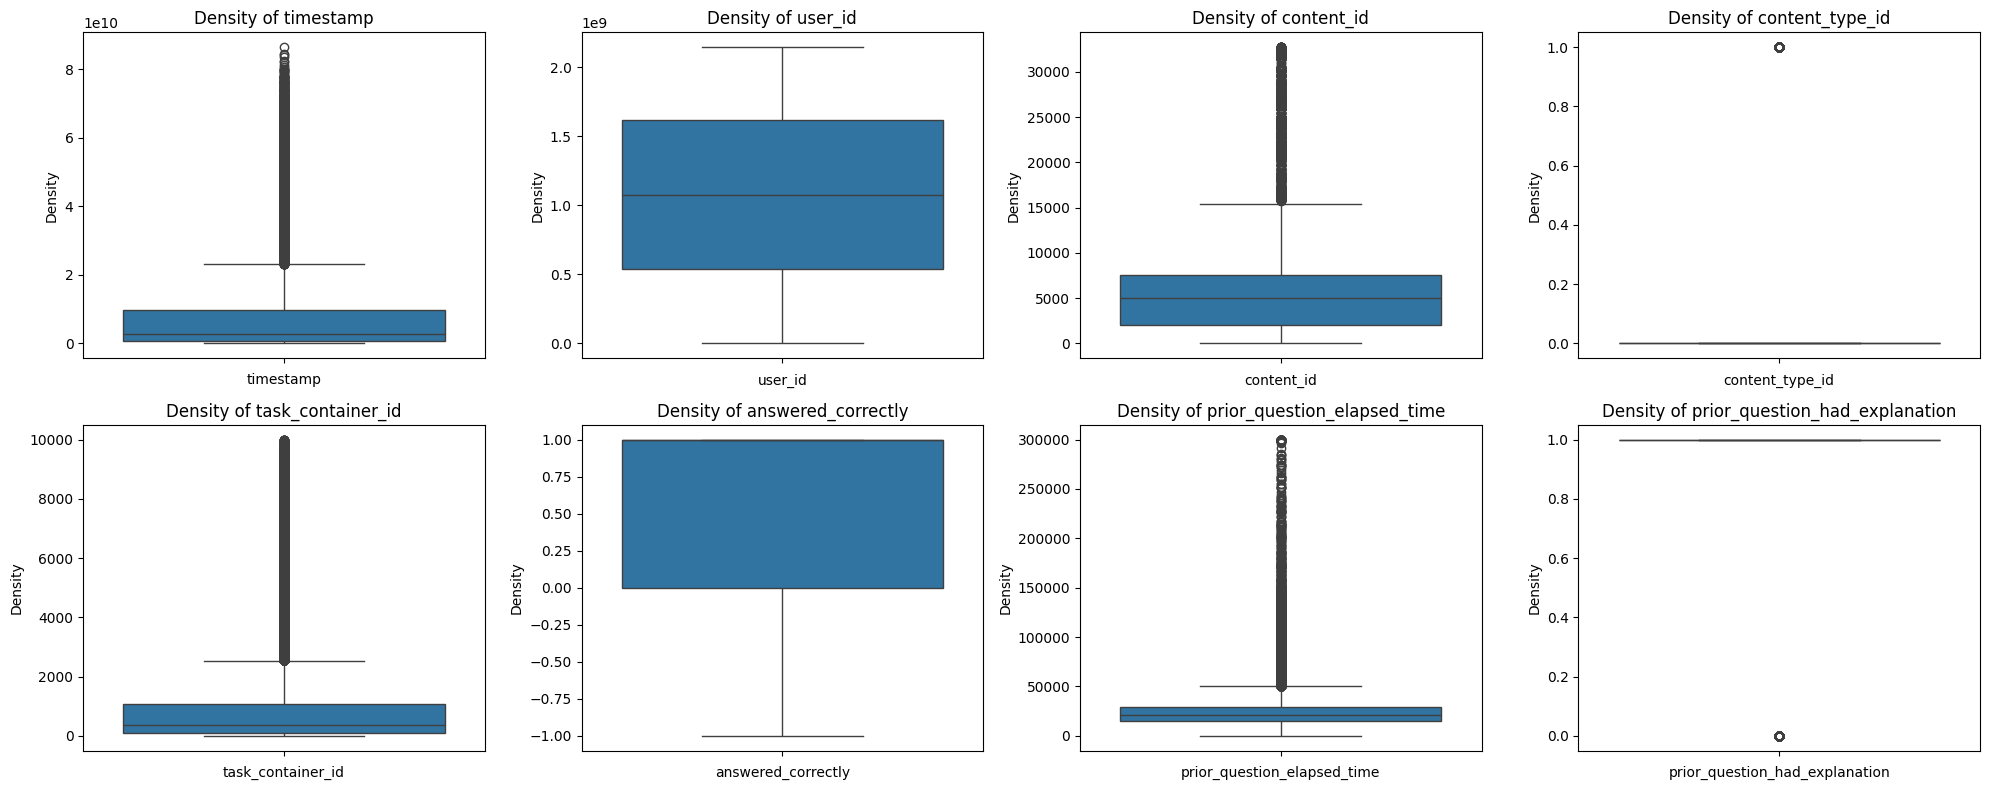

In [37]:
# Select numerical columns
numerical_cols = train_df.select_dtypes(include=np.number).columns

# Calculate the number of rows and columns for the subplots
num_cols = 4  # Number of columns per row
num_rows = int(np.ceil(len(numerical_cols) / num_cols))  # Calculate the number of rows needed

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot boxplots in a loop
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=train_df[col], fill=True, ax=axes[i])
    axes[i].set_title(f'Density of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Hide any extra empty subplots
for i in range(len(numerical_cols), num_rows * num_cols):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate z-scores for each column
z_scores = np.abs((train_df - train_df.mean()) / train_df.std())

# Set threshold for z-scores (e.g., 4 standard deviations from the mean)
threshold = 4

# Remove outliers
train_clean = train_df[(z_scores < threshold).all(axis=1)]
train_clean.reset_index(drop=True, inplace=True)

# Verify the number of rows before and after
print("Original dataset rows:", train_df.shape[0])
print("Dataset rows after removing outliers:", train_clean.shape[0])

# Save the cleaned dataset
train_clean.to_csv("cleaned_dataset_no_outliers.csv", index=False)

# Print the updated DataFrame (uncomment)
# print(train_clean)

#### timestamp

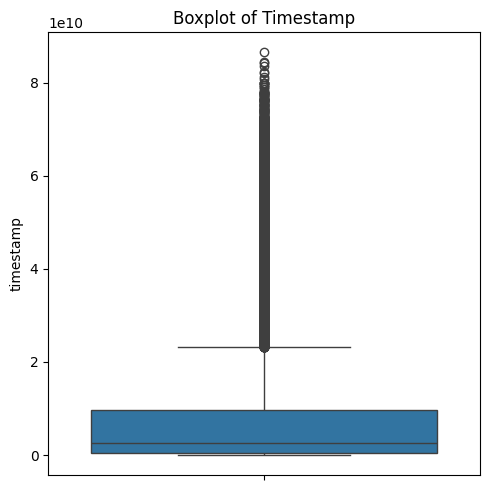

In [38]:
plot_boxplot(train_df, y="timestamp", title="Boxplot of Timestamp")

In [39]:
# Total rows we started with
total = len(train_df)
feature = "timestamp"

# Compute Outliers
Q1 = np.percentile(train_df[feature].values, q = 25)
Q3 = np.percentile(train_df[feature].values, q = 75)
IQR = Q3 - Q1

# We'll look only at the upper interval outliers
outlier_boundry = Q3 + 1.5*IQR

print('Timestamp: around {:.2}% of the data would be erased.'.format(len(train_df[train_df[feature] >= outlier_boundry])/total * 100),
      "\n"+
      'The outlier boundry is {:,}, which means {:,.5} hrs, which means {:,.5} days.'.format(outlier_boundry, (outlier_boundry / 3.6e+6), (outlier_boundry / 3.6e+6)/24))

gc.collect()

Timestamp: around 9.6% of the data would be erased. 
The outlier boundry is 23,267,060,324.0, which means 6,463.1 hrs, which means 269.29 days.


274

Is it ok to erase pretty much 10% of data as outliers or is it valuable data for our predicitions?

The very high values for timestamp show us users that have engaged with the platform for close to a year and up to nearly 3 years. This seems like a valuable data we don't want to lose as we can calculate their progress from that.

#### Engagement count among users

It could potentially be beneficial to erase data for users with low engagement count, e.g. 5, and treat it as outliers. However, these could be fairly new users so have to be careful there to delete their data too as it could have good value for comparison with long standing users and their success on the platform.

In [40]:
user_id_counts = train_df.groupby('user_id').size()

# Display in tabular format
print(user_id_counts)

user_id
2746           1
12741          1
24418         12
91216          1
107002         2
              ..
2147143229     1
2147190658     2
2147192453     1
2147413636     1
2147470777     1
Length: 55698, dtype: int64


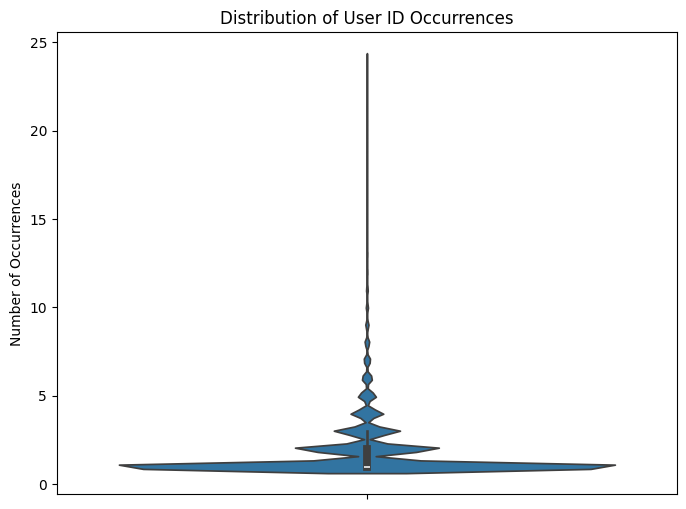

In [41]:
# violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(y=user_id_counts)
plt.title("Distribution of User ID Occurrences")
plt.ylabel("Number of Occurrences")
plt.show()

In [42]:
# Basic descriptive statistics
print("Minimum occurrences:", user_id_counts.min())
print("Maximum occurrences:", user_id_counts.max())
print("Average occurrences:", user_id_counts.mean())
print("Median occurrences:", user_id_counts.median())

Minimum occurrences: 1
Maximum occurrences: 24
Average occurrences: 1.7954863729397823
Median occurrences: 1.0


In [43]:
# Quantiles (e.g., 25th, 50th, 75th percentiles)
quantiles = user_id_counts.quantile([0.25, 0.5, 0.75])
print(quantiles)

0.25    1.0
0.50    1.0
0.75    2.0
dtype: float64


In [44]:
# Specific percentiles (e.g., 90th, 95th, 99th)
percentiles = user_id_counts.quantile([0.9, 0.95, 0.99])
print(percentiles)

0.90    3.0
0.95    5.0
0.99    9.0
dtype: float64


In [45]:
# Specific percentiles (e.g., 1st, 25th, 10th)
percentiles = user_id_counts.quantile([0.01, 0.05, 0.1])
print(percentiles)

0.01    1.0
0.05    1.0
0.10    1.0
dtype: float64


In [46]:
# Export to a CSV file
user_id_counts.to_csv('user_id_counts.csv', header=['count'])
print("User ID counts saved to user_id_counts.csv")

User ID counts saved to user_id_counts.csv


In [47]:
# Group by 'user_id' and count occurrences
user_engagement_counts = train_df.groupby('user_id').size()

# Filter for users with only one engagement
single_engagement_users = user_engagement_counts[user_engagement_counts == 1]

# Count the number of such users
num_single_engagement_users = len(single_engagement_users)

# Print the result
print(f"Number of people who engaged only once: {num_single_engagement_users}")

Number of people who engaged only once: 36510


The bottom 1% users engaged 1-11 times

In [48]:
# Group by 'user_id' and count occurrences
user_engagement_counts = train_df.groupby('user_id').size()

# Filter for users with engagements between 1 and 11
engagement_range_users = user_engagement_counts[
    (user_engagement_counts >= 1) & (user_engagement_counts <= 11)
]

# Count the number of such users
num_engagement_range_users = len(engagement_range_users)

# Print the result
print(
    "Number of people who engaged between 1 and 11 times:"
    f" {num_engagement_range_users}"
)

Number of people who engaged between 1 and 11 times: 55455


Remove the bottom 1% users as outliers

In [ ]:
# Group by 'user_id' and count occurrences
user_engagement_counts = train_df.groupby('user_id').size()

# Filter for users with engagements between 1 and 11
users_to_remove = user_engagement_counts[
    (user_engagement_counts >= 1) & (user_engagement_counts <= 11)
].index

# Remove those users from the main DataFrame
train_df = train_df[~train_df['user_id'].isin(users_to_remove)]

In [ ]:
# Calculate the number of rows removed
rows_removed = len(user_engagement_counts[ (user_engagement_counts >= 1) & (user_engagement_counts <= 11)])

# Print the number of removed rows
print(f"Number of rows removed: {rows_removed}")

Number of rows removed: 55455


# EDA

## Feature exploration

### train

The 'timestamp' variable has values as high as 87 billion miliseconds which tells me nothing so I decided to convert it to days to get a better perspective on what that means for the dataset.

In [49]:
max_timestamp = train_df['timestamp'].max()
max_days = max_timestamp / (1000 * 60 * 60 * 24)  # Convert milliseconds to days
max_years = max_days / 365.25  # Convert days to years (accounting for leap years)

print(f"Maximum timestamp in days: {max_days}")
print(f"Maximum timestamp in years: {max_years}")

Maximum timestamp in days: 1000.8456629166667
Maximum timestamp in years: 2.7401660860141455


So thats about 2 and 3/4 of a year between interactions for the particular user so will have to explore if that is quite unique in the dataset and could be considered an outlier or if the time data really spans that much in general.

How many unique users in the dataset?

In [50]:
num_unique_users = train_df['user_id'].nunique()
print(f"Number of unique users: {num_unique_users}")

Number of unique users: 55698


The 'content_id' is basically a 'question_id' from question.csv or 'lecture_id' from lecture.csv datasets and then the 'content_type_id' defines which one of these is it in the train.csv dataset.

It's boolean where False means if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

In [51]:
train_df.content_type_id.value_counts()

,count
content_type_id,
0,98058
1,1947


In [52]:
num_unique_content = train_df['content_id'].nunique()
print(f"Number of unique content: {num_unique_content}")

# Calculate and print unique questions and lectures in one line
print(f"Unique questions: {train_df[train_df.content_type_id == False].content_id.nunique()}\nUnique lectures: {train_df[train_df.content_type_id == True].content_id.nunique()}")

Number of unique content: 11679
Unique questions: 11452
Unique lectures: 329


It seems that users are given questions in containers and then seeing explanations for them and potentially answers which then may hekp with answering the next batch of questions.

In [53]:
unique_task_container = train_df['task_container_id'].nunique()
print(f"Number of unique task containers: {unique_task_container}")

Number of unique task containers: 6526


The variable 'user_answer' refers to what choice they picked out of multiple answer questions, numbers 0-3 refer to 4 choices, and number -1 means they engaged with a lecture instead.
THIS FEATURE WAS DROPPED FROM THE DATASET.

The count for -1 (lectures) checks with the count in 'content_type_id'.

The variable 'answered_correctly' tells us if users got the question right(1) or wrong(0), or if they engaged with a lecture instead(-1). This is also the target variable for this analysis.

In [54]:
answered_correctly_counts = train_df.answered_correctly.value_counts()
print(answered_correctly_counts)

answered_correctly
 1    64381
 0    33677
-1     1947
Name: count, dtype: int64


The maxiumum elapsed time since last question asked could also potentially have some outliers where people don't finish the container or leave the device withiut answering the question.

In [55]:
max_elapsed_time = train_df['prior_question_elapsed_time'].max()
max_minutes = max_elapsed_time / 60000  # Convert milliseconds to minutes
print(f"Maximum elapsed time: {max_minutes}")

Maximum elapsed time: 5.0


There probably is a cut off at 5 minutes per question.

The last variable in the dataset is probably going to be quite imporatant to compare to predicting if the answers to questions were correct. It states in the description that in the beginning the questions asked were onboarding Qs so there wouldnt be feedback but as a student would progress on the platform they would be given some.

In [56]:
train_df.prior_question_had_explanation.value_counts()


,count
prior_question_had_explanation,
1,88679
0,11326


In [57]:
percentages = train_df.prior_question_had_explanation.value_counts(normalize=True) * 100
percentages

,proportion
prior_question_had_explanation,
1,88.674566
0,11.325434


### questions

question_id - How many unique questions in the dataset?

In [58]:
num_unique_questions = questions_df['question_id'].nunique()
print(f"Number of unique questions: {num_unique_questions}")

Number of unique questions: 13522


bundle_id - How many unique question bundles in the dataset?

In [59]:
num_unique_bundles = questions_df['bundle_id'].nunique()
print(f"Number of unique question bundles: {num_unique_bundles}")

Number of unique question bundles: 9764


correct_answer

In [60]:
questions_df.correct_answer.value_counts()

,count
correct_answer,
0,3716
3,3544
1,3478
2,2784


part - the relevant section of the TOEIC test.

https://www.iibc-global.org/english/toeic/test/lr/about/format.html

The Test of English for International Communication (TOEIC) is an international standardized test of English language proficiency for non-native speakers.

In [61]:
questions_df.part.value_counts()

,count
part,
5,5511
2,1647
3,1562
4,1439
6,1211
7,1160
1,992


tags

In [62]:
num_unique_tags = questions_df['tags'].nunique()
print(f"Number of unique tags: {num_unique_tags}")

Number of unique tags: 1519


### lectures

lecture_id - How many unique lectures in the dataset?

In [63]:
num_unique_lectures = lectures_df['lecture_id'].nunique()
print(f"Number of unique lectures: {num_unique_lectures}")

Number of unique lectures: 418


part - TOEIC test

https://www.iibc-global.org/english/toeic/test/lr/about/format.html

The Test of English for International Communication (TOEIC) is an international standardized test of English language proficiency for non-native speakers.

In [64]:
lectures_df.part.value_counts()

,count
part,
5,143
6,83
2,56
1,54
7,32
4,31
3,19


tag

In [65]:
num_unique_tags = lectures_df['tag'].nunique()
print(f"Number of unique tags: {num_unique_tags}")

Number of unique tags: 151


type_of

In [66]:
lectures_df.type_of.value_counts()

,count
type_of,
concept,222
solving question,186
intention,7
starter,3


## Visualisations

### timestamp and prior_question_elapsed_time

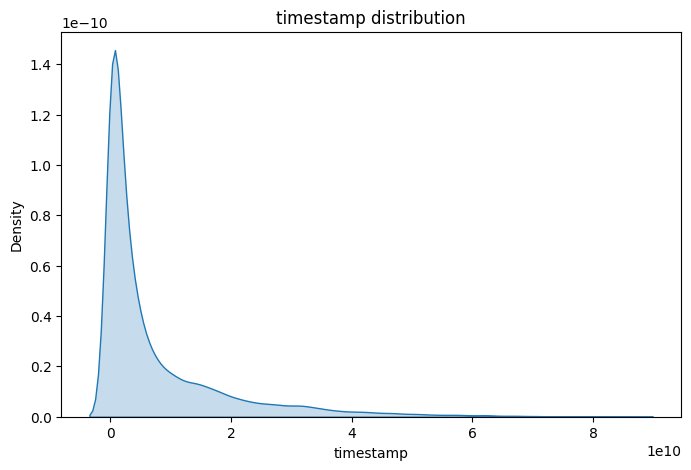

Mean: 7,590,301,149.591371
Median: 2,621,614,831.0
Max: 86,473,065,276


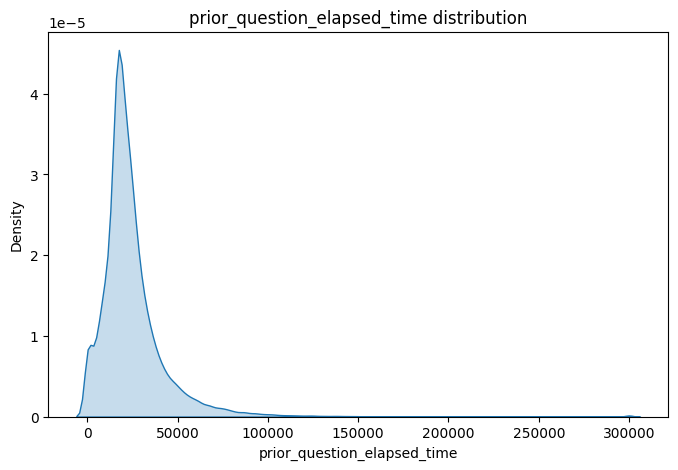

Mean: 24,802.560546875
Median: 21,000.0
Max: 300,000.0


In [67]:
numerical_columns = ['timestamp', 'prior_question_elapsed_time']

for column in numerical_columns:
    plot_kde(train_df, column=column, hue=None, title=column + " distribution")

Histogram for timestamp? Most distribution is within the first 2 months of signing up to the platform - every user starts with 0 value for their first log - does the number of 0 values for timestamp check with number of users?

Check unique number count for user_id

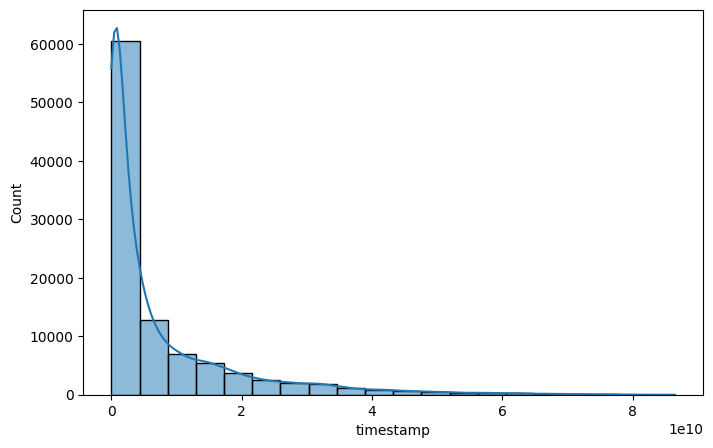

In [68]:
plot_histogram(train_df, 'timestamp', bins=20, hue=None, title=None)

### user_id, content_id and task_container_id

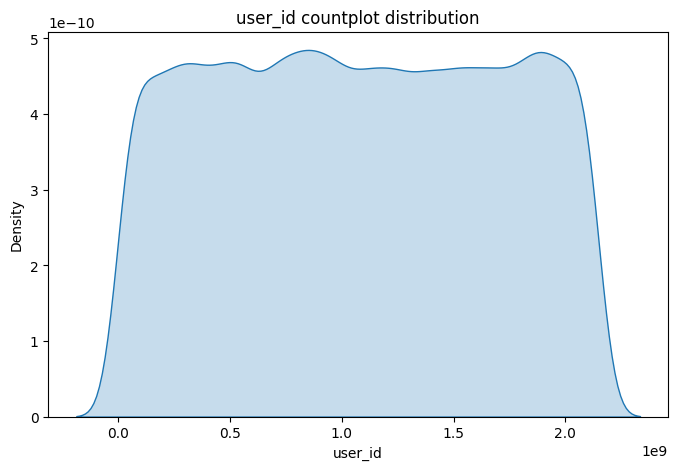

Mean: 1,076,705,115.6046898
Median: 1,071,813,472.0
Max: 2,147,470,777


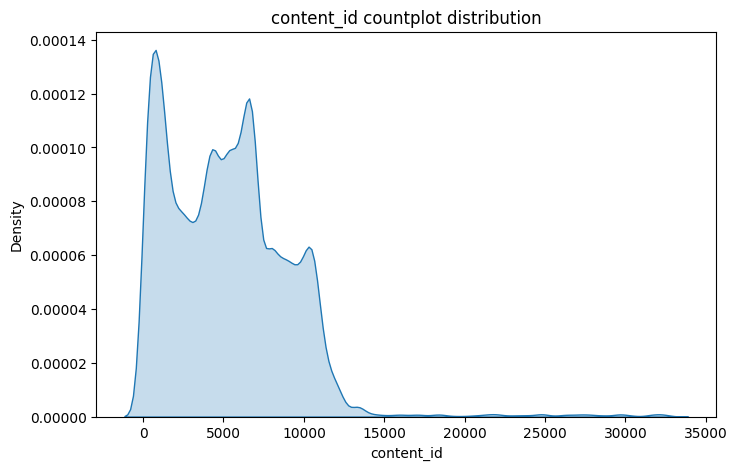

Mean: 5,233.60393980301
Median: 5,037.0
Max: 32,736


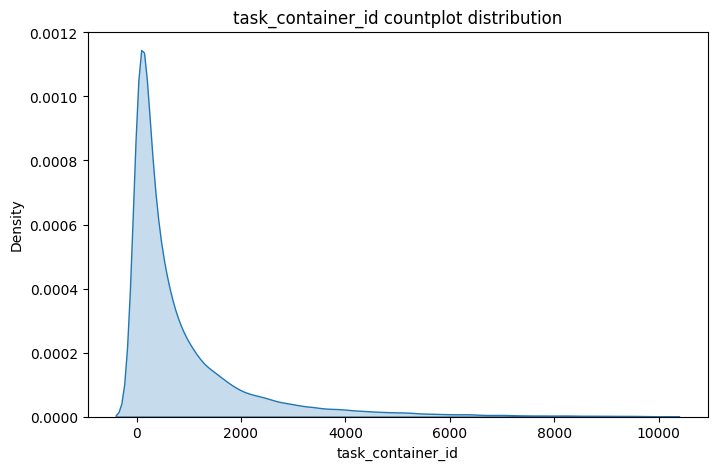

Mean: 887.8576571171442
Median: 379.0
Max: 9,997


In [69]:
categorical_columns = ['user_id', 'content_id', 'task_container_id']

for column in categorical_columns:
    plot_kde(train_df, column=column, hue=None, title=column + " countplot distribution")

### content_type_id, answered_correctly and prior_question_had_explanation

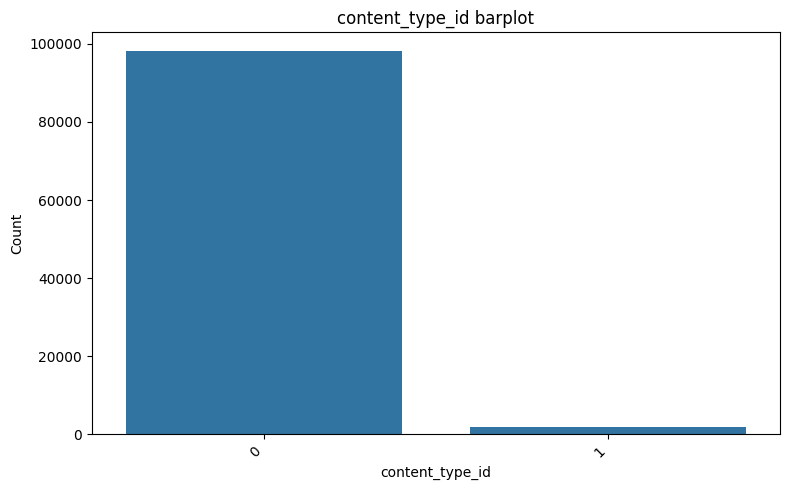

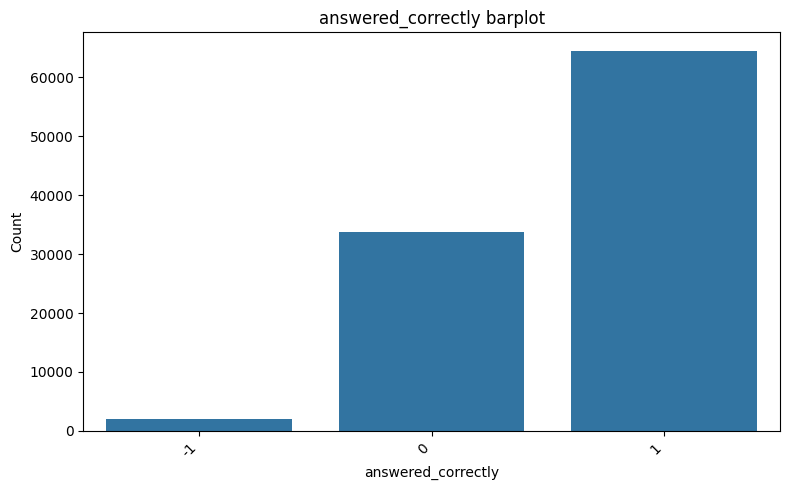

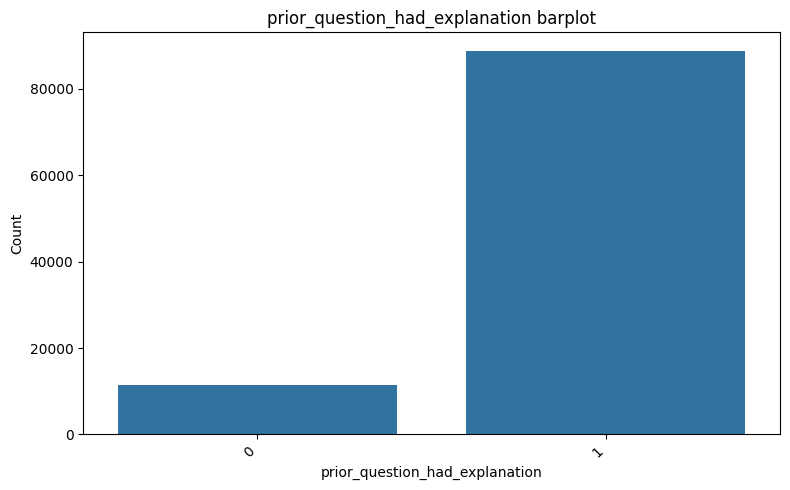

In [70]:
categorical_columns_few = ['content_type_id', 'answered_correctly', 'prior_question_had_explanation']

for column in categorical_columns_few:
    plot_bar(train_df, x=column, y=None, title=column + " barplot")

### correct_answer and part

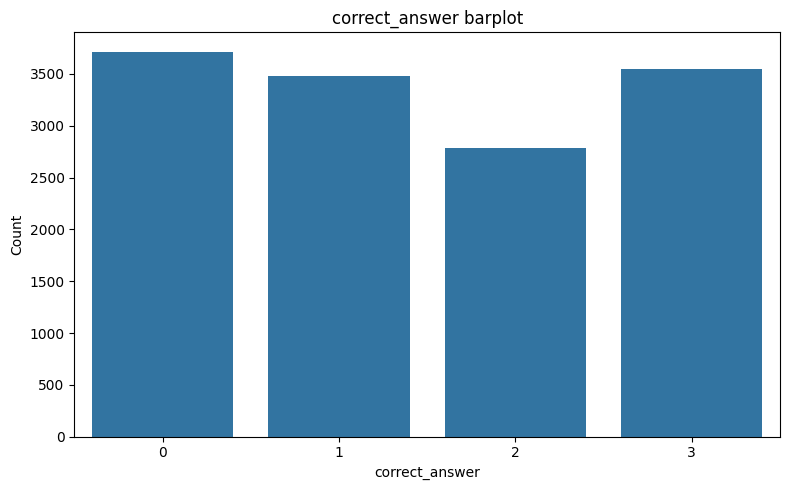

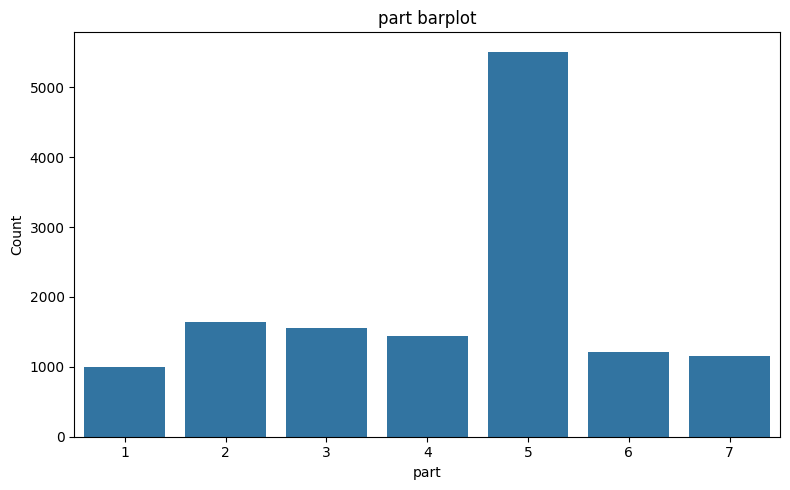

In [71]:
categorical_questions = ['correct_answer', 'part']

for column in categorical_questions:
    plot_bar(questions_df, x=column, y=None, title=column + " barplot", rotate_labels=False)

### part and type_of

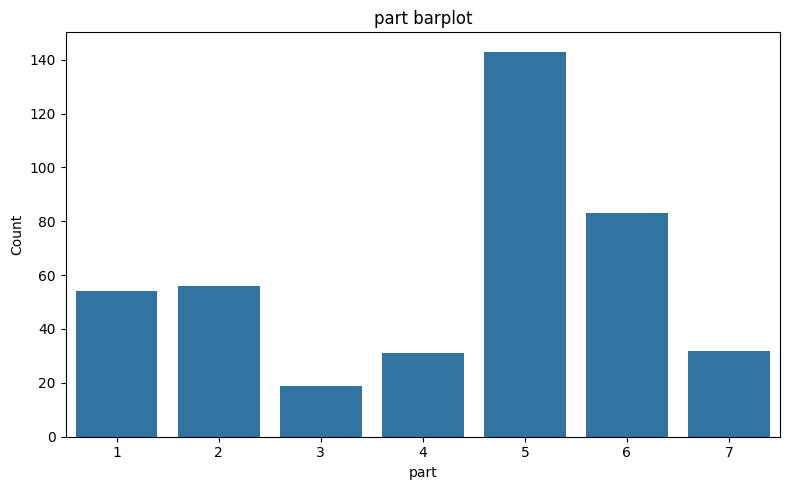

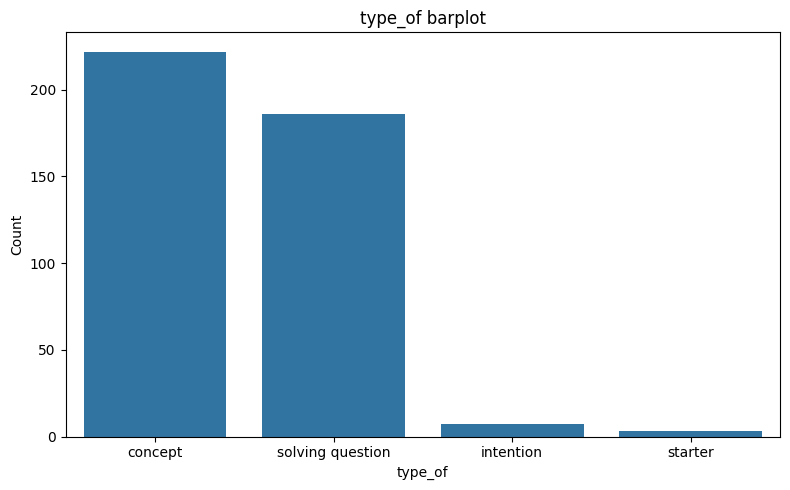

In [72]:
categorical_lectures = ['part', 'type_of']

for column in categorical_lectures:
    plot_bar(lectures_df, x=column, y=None, title=column + " barplot", rotate_labels=False)

## Correlation

 Heat map

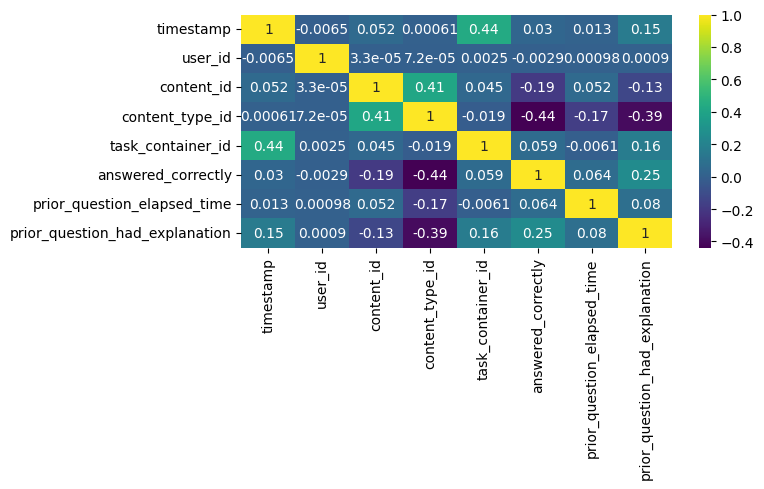

<Axes: >

In [73]:
# Select only numerical features for correlation
numerical_features = train_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Now plot the heatmap
plot_heatmap(correlation_matrix)

## Target variable = answered_correctly

Does the frequency of a unique user's engagement with the system relate to their overall performance quality? Does their performance tend to improve as they complete more assessments or answer more questions (their performance rate grows with each question/assessment)?

In [74]:
# Count how many times the user answered correctly out of all available times
user_performance = train_df.groupby("user_id").agg({'answered_correctly': ['count', 'sum']}).reset_index()
user_performance.columns = ["user_id", "total_count", "correct_count"]
user_performance["performance"] = user_performance["correct_count"] / user_performance["total_count"]

# Create intervals for number of appearences
# between 0 and 1000, 1000 and 2500 and 2500+
def condition(x):
    if x <= 1000:
        return 0
    elif (x > 1000) & (x <= 2500):
        return 1
    else:
        return 2

# Use apply instead of applymap to work with a Series
user_performance["total_interval"] = user_performance["total_count"].apply(condition)

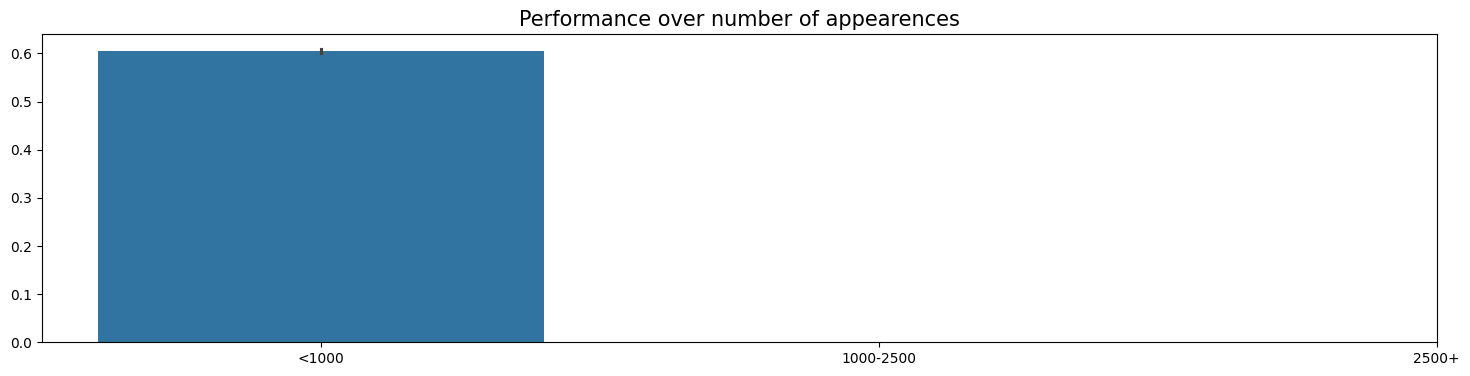

In [75]:
# Convert to numpy arrays
x = user_performance["total_interval"].values
y = user_performance["performance"].values

# Plot
plt.figure(figsize = (18, 4))
sns.barplot(x = x, y = y)
plt.title("Performance over number of appearences", fontsize = 15)
plt.xticks([0, 1, 2], ['<1000', '1000-2500', '2500+']);

del user_performance

Students who engage more frequently with the platform tend to show improvements in their average performance over time.

Does the fact that a user interacted with lectures relate to their overall performance?

In [76]:
# Get unique user_ids who have watched at least one lecture
users_who_watched_lectures = train_df[train_df['content_type_id'] == 1]['user_id'].unique()

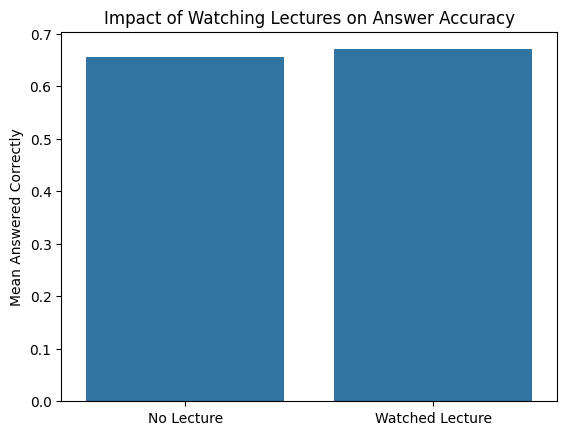

In [77]:
# Calculate mean accuracy for users who watched lectures
accuracy_watched = train_df[train_df['user_id'].isin(users_who_watched_lectures) & (train_df['content_type_id'] == 0)]['answered_correctly'].mean()

# Calculate mean accuracy for users who never watched lectures
accuracy_not_watched = train_df[~train_df['user_id'].isin(users_who_watched_lectures)]['answered_correctly'].mean()

# Plot the comparison
sns.barplot(x=['No Lecture', 'Watched Lecture'], y=[accuracy_not_watched, accuracy_watched])
plt.title("Impact of Watching Lectures on Answer Accuracy")
plt.ylabel("Mean Answered Correctly")
plt.show()

If users who watched lectures have higher accuracy, lecture-watching is important.

If the difference is small, it might not be a useful feature.

# Feature engineering

## Feature creation

One-hot encoding: Converting categorical variables to binary columns

In [78]:
categorical_cols_lectures = ['part', 'type_of']  # Columns for one-hot encoding

lectures_encoded = lectures_df.copy()  # Create a copy of the DataFrame

# Apply one-hot encoding with dtype=int to get binary values and drop original columns
# Create a dictionary mapping columns to their prefixes
prefix_mapping = {'part': 'part', 'type_of': 'type'}

for col in categorical_cols_lectures:
    # Use the prefix from the mapping
    one_hot_encoded = pd.get_dummies(lectures_df[col], prefix=prefix_mapping[col])
    lectures_encoded = pd.concat([lectures_encoded, one_hot_encoded], axis=1)
    lectures_encoded.drop(columns=[col], inplace=True)  # Drop the original column

# Change boolean columns to int8
for col in lectures_encoded.select_dtypes(include=['bool']).columns:
    lectures_encoded[col] = lectures_encoded[col].astype(int).astype('int8')

lectures_encoded.head()

,lecture_id,tag,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_concept,type_intention,type_solving question,type_starter
0,89,159,0,0,0,0,1,0,0,1,0,0,0
1,100,70,1,0,0,0,0,0,0,1,0,0,0
2,185,45,0,0,0,0,0,1,0,1,0,0,0
3,192,79,0,0,0,0,1,0,0,0,0,1,0
4,317,156,0,0,0,0,1,0,0,0,0,1,0


In [79]:
lectures_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   lecture_id             418 non-null    int16
 1   tag                    418 non-null    int16
 2   part_1                 418 non-null    int8 
 3   part_2                 418 non-null    int8 
 4   part_3                 418 non-null    int8 
 5   part_4                 418 non-null    int8 
 6   part_5                 418 non-null    int8 
 7   part_6                 418 non-null    int8 
 8   part_7                 418 non-null    int8 
 9   type_concept           418 non-null    int8 
 10  type_intention         418 non-null    int8 
 11  type_solving question  418 non-null    int8 
 12  type_starter           418 non-null    int8 
dtypes: int16(2), int8(11)
memory usage: 6.3 KB


In [80]:
categorical_cols_questions = ['correct_answer', 'part']  # Columns for one-hot encoding

questions_encoded = questions_df.copy()  # Create a copy of the DataFrame

# Apply one-hot encoding with dtype=int to get binary values and drop original columns
# Create a dictionary mapping columns to their prefixes
prefix_mapping = {'correct_answer': 'correct_answer', 'part': 'part'}

for col in categorical_cols_questions:
    # Use the prefix from the mapping
    one_hot_encoded = pd.get_dummies(questions_df[col], prefix=prefix_mapping[col])
    questions_encoded = pd.concat([questions_encoded, one_hot_encoded], axis=1)
    questions_encoded.drop(columns=[col], inplace=True)  # Drop the original column

# Change boolean columns in to int8
for col in questions_encoded.select_dtypes(include=['bool']).columns:
    questions_encoded[col] = questions_encoded[col].astype(int).astype('int8')

questions_encoded.head()

,question_id,bundle_id,tags,correct_answer_0,correct_answer_1,correct_answer_2,correct_answer_3,part_1,part_2,part_3,part_4,part_5,part_6,part_7
0,0,0,51 131 162 38,1,0,0,0,1,0,0,0,0,0,0
1,1,1,131 36 81,0,1,0,0,1,0,0,0,0,0,0
2,2,2,131 101 162 92,1,0,0,0,1,0,0,0,0,0,0
3,3,3,131 149 162 29,1,0,0,0,1,0,0,0,0,0,0
4,4,4,131 5 162 38,0,0,0,1,1,0,0,0,0,0,0


In [81]:
questions_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13522 entries, 0 to 13522
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   question_id       13522 non-null  int16 
 1   bundle_id         13522 non-null  int16 
 2   tags              13522 non-null  object
 3   correct_answer_0  13522 non-null  int8  
 4   correct_answer_1  13522 non-null  int8  
 5   correct_answer_2  13522 non-null  int8  
 6   correct_answer_3  13522 non-null  int8  
 7   part_1            13522 non-null  int8  
 8   part_2            13522 non-null  int8  
 9   part_3            13522 non-null  int8  
 10  part_4            13522 non-null  int8  
 11  part_5            13522 non-null  int8  
 12  part_6            13522 non-null  int8  
 13  part_7            13522 non-null  int8  
dtypes: int16(2), int8(11), object(1)
memory usage: 409.4+ KB


In [82]:
# Check missing values
missing_values_questions = questions_encoded.isna().sum().to_frame('missing_values')
print("Missing values in questions_encoded:\n", missing_values_questions)


missing_values_lectures = lectures_encoded.isna().sum().to_frame('missing_values')
print("\nMissing values in lectures_encoded:\n", missing_values_lectures)

Missing values in questions_encoded:
                   missing_values
question_id                    0
bundle_id                      0
tags                           0
correct_answer_0               0
correct_answer_1               0
correct_answer_2               0
correct_answer_3               0
part_1                         0
part_2                         0
part_3                         0
part_4                         0
part_5                         0
part_6                         0
part_7                         0

Missing values in lectures_encoded:
                        missing_values
lecture_id                          0
tag                                 0
part_1                              0
part_2                              0
part_3                              0
part_4                              0
part_5                              0
part_6                              0
part_7                              0
type_concept                        0
type_intent

Learning Progress Features

Knowledge growth rate: Change in correctness over time

In [83]:

# Sort data by user and time
train_sorted = train_df.sort_values(['user_id', 'timestamp'])  # Replace 'timestamp' with your actual time column

# Create time bins (e.g., by day, week, or by groups of N questions)
# Option 1: By time periods
train_sorted['time_bin'] = pd.cut(train_sorted['timestamp'], bins=10)  # 10 equal time bins

# Create time bins (e.g., weeks, months)
# Example: Creating weekly bins
train_sorted['time_bin'] = pd.cut(
    train_sorted['timestamp'], bins=np.arange(0, train_sorted['timestamp'].max() + 604800000, 604800000)
)  # Weekly bins (604800000 milliseconds = 1 week)

# Option 2: By question sequence (every N questions)
train_sorted['question_seq'] = train_sorted.groupby('user_id').cumcount()
train_sorted['question_bin'] = train_sorted['question_seq'] // 10  # Every 10 questions

# Calculate average correctness per user and time bin and directly assign to 'correctness_rate' column
growth_rate = train_sorted[
    (train_sorted.answered_correctly != -1)
    & (train_sorted.prior_question_had_explanation != -1)
].groupby(['user_id', 'time_bin'], observed=False)['answered_correctly'].agg('mean').reset_index().rename(columns={'answered_correctly': 'correctness_rate'})

# Calculate the change between consecutive time periods
growth_rate_change = growth_rate.sort_values(['user_id', 'time_bin'])
growth_rate_change['previous_rate'] = growth_rate_change.groupby('user_id')['correctness_rate'].shift(1)
growth_rate_change['growth_rate'] = growth_rate_change['correctness_rate'] - growth_rate_change['previous_rate']

# Calculate average growth rate per user
user_avg_growth = growth_rate_change.groupby('user_id')['growth_rate'].mean()

# Calculate the change between consecutive time periods
growth_rate_change = growth_rate.sort_values(['user_id', 'time_bin'])
growth_rate_change['previous_rate'] = growth_rate_change.groupby('user_id')['correctness_rate'].shift(1)
growth_rate_change['growth_rate'] = growth_rate_change['correctness_rate'] - growth_rate_change['previous_rate']

# Calculate average growth rate per user
user_avg_growth = growth_rate_change.groupby('user_id')['growth_rate'].mean()

In [84]:
user_avg_growth.head()

,growth_rate
user_id,
2746,NaN
12741,NaN
24418,0.0
91216,NaN
107002,NaN


Merge with train_df

In [85]:
train_df = pd.merge(train_df, user_avg_growth, on='user_id', how='left')

In [86]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,growth_rate
0,376471,12289792,2946,0,6,0,33000.0,0,NaN
1,1830282507,18457289,399,0,211,1,16000.0,1,NaN
2,1636362340,21299553,736,0,188,1,18000.0,1,NaN
3,257501,9339691,3363,0,5,0,36333.0,0,NaN
4,2608250009,22377749,4992,0,1183,0,26000.0,1,-1.0


In [87]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   timestamp                       100005 non-null  int64  
 1   user_id                         100005 non-null  int32  
 2   content_id                      100005 non-null  int16  
 3   content_type_id                 100005 non-null  int8   
 4   task_container_id               100005 non-null  int16  
 5   answered_correctly              100005 non-null  int8   
 6   prior_question_elapsed_time     100005 non-null  float32
 7   prior_question_had_explanation  100005 non-null  int8   
 8   growth_rate                     31691 non-null   float64
dtypes: float32(1), float64(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 3.0 MB


# Merging datasets

Goal is to merge train, questions and lectures datasets for model building

question_id is a foreign key for the train/test content_id column, when the content type is question (0)

lecture_id is a foreign key for the train/test content_id column, when the content type is lecture (1)

Create copies to test code

In [88]:
train_df_copy = train_df.copy()
questions_df_copy = questions_encoded.copy()
lectures_df_copy = lectures_encoded.copy()

print("Copies of datasets created successfully.")

Copies of datasets created successfully.


In [89]:
def merge_datasets(train_df_copy, questions_df_copy, lectures_df_copy):
    """
    Merge three datasets: train_df, questions_df, and lectures_df.

    Parameters:
    - train_df: DataFrame containing 'content_id' as the key column
    - questions_df: DataFrame containing 'question_id' that links to 'content_id' in train_df
    - lectures_df: DataFrame containing 'lecture_id' that links to 'content_id' in train_df

    Returns:
    - merged_df: The complete merged DataFrame
    """
    # First, merge train_df with questions_df
    # We'll use a left merge to keep all rows from train_df
    questions_merged = train_df_copy.merge(
        questions_df_copy,
        left_on='content_id',
        right_on='question_id',
        how='left',
        suffixes=('', '_question')
    )

    # Merge train_df with lectures_df using 'content_id' and 'lecture_id' (without filtering)
    lectures_merged = train_df_copy.merge(
        lectures_df_copy,
        left_on='content_id',
        right_on='lecture_id',
        how='left',
    )

    # Handle the common part_1 to part_7 columns to avoid confusion
    # For each common column, create a new column that takes the value from either source
    for i in range(1, 8):
        part_col = f'part_{i}'
        question_col = f'{part_col}'  # If no suffix was added in first merge
        lecture_col = f'{part_col}_lecture'

    final_merged = pd.concat([questions_merged, lectures_merged], ignore_index=True)

    return final_merged

# Example usage
# merged_df = merge_datasets(train_df, questions_df, lectures_df)

In [90]:
merged_df = merge_datasets(train_df_copy, questions_df_copy, lectures_df_copy)

In [91]:
merged_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,growth_rate,question_id,...,part_4,part_5,part_6,part_7,lecture_id,tag,type_concept,type_intention,type_solving question,type_starter
0,376471,12289792,2946,0,6,0,33000.0,0,NaN,2946.0,...,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1830282507,18457289,399,0,211,1,16000.0,1,NaN,399.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1636362340,21299553,736,0,188,1,18000.0,1,NaN,736.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,257501,9339691,3363,0,5,0,36333.0,0,NaN,3363.0,...,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2608250009,22377749,4992,0,1183,0,26000.0,1,-1.0,4992.0,...,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200010 entries, 0 to 200009
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   timestamp                       200010 non-null  int64  
 1   user_id                         200010 non-null  int32  
 2   content_id                      200010 non-null  int16  
 3   content_type_id                 200010 non-null  int8   
 4   task_container_id               200010 non-null  int16  
 5   answered_correctly              200010 non-null  int8   
 6   prior_question_elapsed_time     200010 non-null  float32
 7   prior_question_had_explanation  200010 non-null  int8   
 8   growth_rate                     63382 non-null   float64
 9   question_id                     98827 non-null   float64
 10  bundle_id                       98827 non-null   float64
 11  tags                            98827 non-null   object 
 12  correct_answer_0

In [93]:
# Find NaN values in the merged_df DataFrame
nan_counts = merged_df.isna().sum()

# Print the columns with NaN values and their counts
print("NaN values in merged_df:")
print(nan_counts[nan_counts > 0])

NaN values in merged_df:
growth_rate              136628
question_id              101183
bundle_id                101183
tags                     101183
correct_answer_0         101183
correct_answer_1         101183
correct_answer_2         101183
correct_answer_3         101183
part_1                    97948
part_2                    97948
part_3                    97948
part_4                    97948
part_5                    97948
part_6                    97948
part_7                    97948
lecture_id               196775
tag                      196775
type_concept             196775
type_intention           196775
type_solving question    196775
type_starter             196775
dtype: int64


In [94]:
# Replace NaN values with 0 in merged_df
merged_df.fillna(0, inplace=True)

# Check if NaN values have been removed
nan_counts = merged_df.isna().sum()
print("NaN values in merged_df after filling:")
print(nan_counts[nan_counts > 0])

NaN values in merged_df after filling:
Series([], dtype: int64)


In [95]:
for column in merged_df.select_dtypes(include=['float64']).columns:
    merged_df[column] = merged_df[column].astype('int8')

In [96]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200010 entries, 0 to 200009
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   timestamp                       200010 non-null  int64  
 1   user_id                         200010 non-null  int32  
 2   content_id                      200010 non-null  int16  
 3   content_type_id                 200010 non-null  int8   
 4   task_container_id               200010 non-null  int16  
 5   answered_correctly              200010 non-null  int8   
 6   prior_question_elapsed_time     200010 non-null  float32
 7   prior_question_had_explanation  200010 non-null  int8   
 8   growth_rate                     200010 non-null  int8   
 9   question_id                     200010 non-null  int8   
 10  bundle_id                       200010 non-null  int8   
 11  tags                            200010 non-null  object 
 12  correct_answer_0

Drop content_type_id, tags, and tag for now

In [97]:
merged_df.drop(columns=['tag', 'tags', 'content_type_id'], inplace=True)

# Train-val-test split

## For main model

Split x and y variables and perform train-test split before scaling the dataset to prevent data leakage and ensure model is trained on realistic representation of unseen data.

In [98]:
# Define features (X) and target (y)
X = merged_df.drop('answered_correctly', axis=1) # Features are all columns except the target
y = merged_df['answered_correctly'] # Target is the 'answered_correctly' column

In [99]:
# Do I need to use stratify=y ?
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [100]:
# First split: training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
# approximately 60% train, 20% validation, 20% test

## For model with embedding

In [ ]:
def time_based_split(numerical_features, user_ids, content_ids, targets, val_ratio=0.15, test_ratio=0.15):
    """
    Split data chronologically for time series forecasting
    """
    n_samples = len(targets)
    test_size = int(n_samples * test_ratio)
    val_size = int(n_samples * val_ratio)
    train_size = n_samples - test_size - val_size

    # Split indices (assuming data is already sorted chronologically)
    train_idx = slice(0, train_size)
    val_idx = slice(train_size, train_size + val_size)
    test_idx = slice(train_size + val_size, n_samples)

    splits = {
        'train': {
            'numerical_input': numerical_features[train_idx],
            'user_id_input': user_ids[train_idx].reshape(-1, 1),
            'content_id_input': content_ids[train_idx].reshape(-1, 1),
            'targets': targets[train_idx]
        },
        'val': {
            'numerical_input': numerical_features[val_idx],
            'user_id_input': user_ids[val_idx].reshape(-1, 1),
            'content_id_input': content_ids[val_idx].reshape(-1, 1),
            'targets': targets[val_idx]
        },
        'test': {
            'numerical_input': numerical_features[test_idx],
            'user_id_input': user_ids[test_idx].reshape(-1, 1),
            'content_id_input': content_ids[test_idx].reshape(-1, 1),
            'targets': targets[test_idx]
        }
    }

    return splits

## Validation test - Ignore the code cells below for now

I'll help you understand what this code is doing:

1. `validation = train.groupby('user_id').tail(5)` takes the 5 most recent answers from each user in the dataset and assigns them to a validation set.

2. `train = train[~train.index.isin(validation.index)]` removes these validation samples from the original training set.

3. `len(train) + len(validation)` shows the total number of records (9,804,604) after this split.

4. `len(validation)` would show how many records are in the validation set, but the output isn't shown in your excerpt.

This is a common approach for time-series validation in recommendation systems or user modeling, where you want to validate on each user's most recent interactions. It ensures that your model is evaluated on future data while being trained on past data, which better reflects how it would perform in production.

Using `train_test_split` would create a random split of your data, which isn't ideal for this scenario for several reasons:

1. **Temporal nature of the data**: Since you're working with user answers over time, a random split would mix up the chronological order. By using `groupby('user_id').tail(5)`, you're specifically selecting each user's most recent 5 answers for validation, which preserves the temporal structure.

2. **User-level evaluation**: This approach ensures every user appears in both training and validation sets, which allows you to evaluate how well your model generalizes to new behaviors from the same users.

3. **Cold-start problem avoidance**: A random split might put all of a user's data in either training or testing, creating a "cold-start" scenario where you're evaluating on users you've never seen before. This split avoids that issue.

4. **Realistic deployment scenario**: In a real-world recommendation system, you typically train on users' historical interactions and want to predict their future behavior - this split mimics that scenario.

5. **Leakage prevention**: Taking the most recent interactions prevents data leakage where you train on future data and test on past data, which would give artificially inflated performance metrics.

For time-series data or user interaction data, this chronological split is often more appropriate than a random `train_test_split`.

Stratified sampling by user activity: If some users have many more interactions than others, you might want to stratify your sampling to ensure representation across different user activity levels.

In [ ]:
# First categorize users by activity level
user_counts = train.groupby('user_id').size()
activity_bins = pd.qcut(user_counts, 4, labels=['low', 'medium', 'high', 'very_high'])
train['activity_level'] = train['user_id'].map(activity_bins)

# Then stratify by activity level
from sklearn.model_selection import train_test_split
train_subset, validation = train_test_split(train, test_size=0.2, stratify=train['activity_level'])

In [ ]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Scaling

## MinMaxScaler - DO NOT USE

In [ ]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit the scaler on the training data (X_train)
scaler.fit(X_train)
# Create a copy to avoid modifying the original
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
# Transform training and testing data to 0-1 range
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Convert to a dataframe, for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()
X_test_scaled.head()

## StandardScaler - USE THIS ONE

Scale only 'prior_question_elapsed_time' feature

In [101]:
# Convert 'prior_question_elapsed_time' to seconds
X_train['prior_question_elapsed_time'] = X_train['prior_question_elapsed_time'] / 1000  # Convert from ms to sec
X_test['prior_question_elapsed_time'] = X_test['prior_question_elapsed_time'] / 1000  # Convert from ms to sec
# Initialize StandardScaler
scaler = StandardScaler()
# Fit the scaler only on 'prior_question_elapsed_time'
scaler.fit(X_train[['prior_question_elapsed_time']])
# Create a copy to avoid modifying the original
X_train_standardized = X_train.copy()
X_test_standardized = X_test.copy()

# Transform(scale) only the 'prior_question_elapsed_time' column
X_train_standardized['prior_question_elapsed_time'] = scaler.transform(X_train[['prior_question_elapsed_time']])
X_test_standardized['prior_question_elapsed_time'] = scaler.transform(X_test[['prior_question_elapsed_time']])

# Convert back to a dataframe, for better readability
X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns)
X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_test.columns)

# View the results
X_train_standardized.head(), X_test_standardized.head()

(          timestamp     user_id  content_id  task_container_id  \
 80797    4627084398  1737743869        3859                199   
 113004    263100578   275378631        2084                 59   
 84953    9025249618  1836350725        5159                828   
 108625  13795780921   197747512        5504               3292   
 133937      4294715   736629284        4065                 53   
 
         prior_question_elapsed_time  prior_question_had_explanation  \
 80797                      0.403065                               1   
 113004                     0.072645                               1   
 84953                     -0.092540                               1   
 108625                    -0.142100                               1   
 133937                    -0.588145                               1   
 
         growth_rate  question_id  bundle_id  correct_answer_0  ...  part_3  \
 80797             0           19         19                 0  ...       0   
 113

Scale whole dataframe

In [ ]:
# Initialize StandardScaler
scaler = StandardScaler()
# Fit the scaler on the training data (X_train)
scaler.fit(X_train)
# Create a copy to avoid modifying the original
X_train_standardized = X_train.copy()
X_test_standardized = X_test.copy()
# Transform training and testing data
X_train_standardized = scaler.transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Convert to a dataframe, for better readability
X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns)  # Use X_train.columns for column names
X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_test.columns)  # Use X_test.columns for column names

X_train_standardized.head()
X_test_standardized.head()

# LightGBM / XGBoost model

Prepare Features:

* Convert prior_question_elapsed_time to seconds and scale it using StandardScaler(optional for boosting models but scaling ensures consistency across models when compared with an LSTM model).

* Category encoding - use one-hot encoding before training

* When creating the DMatrix, tell XGBoost that these are categorical

LightGBM Model (with early stopping):

In [114]:
# Train LightGBM Model
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    metric='auc',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    random_state=42  # No categorical_feature needed
)

In [115]:
# Filter out rows with -1 in y_train and y_val
train_mask = y_train != -1
val_mask = y_val != -1

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_val = X_val[val_mask]
y_val = y_val[val_mask]

# Convert the target variable to binary format (0 and 1)
# This is likely already done in your code, but it's good to be explicit
y_train = y_train.astype(int)
y_val = y_val.astype(int)

# Fit the model and use early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50)], # Use the early_stopping callback
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 77335, number of negative: 40369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1873
[LightGBM] [Info] Number of data points in the train set: 117704, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.657029 -> initscore=0.650084
[LightGBM] [Info] Start training from score 0.650084
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.604477


LGBMClassifier(learning_rate=0.05, max_depth=7, metric='auc', n_estimators=500,
               objective='binary', random_state=42)

In [ ]:
# Before fitting the model
# Filter out any rows where 'answered_correctly' is -1
# This will ensure your training data only contains 0 and 1 for the target variable
X_train = X_train[y_train != -1]
y_train = y_train[y_train != -1]

# Additionally, do the same filtering for your validation set:
X_val = X_val[y_val != -1]
y_val = y_val[y_val != -1]

In [116]:
# Make predictions
y_pred = model.predict_proba(X_val)[:,1] # Get probabilities for class 1

In [117]:
# Evaluate Performance
auc_score = roc_auc_score(y_val, y_pred)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.6045


XGBoost Model (with early stopping):

In [118]:
# Convert Data to XGBoost DMatrix Format (Optimized for Speed)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [119]:
# Define XGBoost Parameters
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'auc',  # AUC for performance measurement
    'learning_rate': 0.05,  # Step size shrinkage
    'max_depth': 7,  # Depth of trees
    'subsample': 0.8,  # Prevent overfitting by using 80% of data per tree
    'colsample_bytree': 0.8,  # Use 80% of features per tree
    'random_state': 42
}

In [120]:
# Train XGBoost Model with Early Stopping
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=10
)

[0]	train-auc:0.60254	eval-auc:0.58435
[10]	train-auc:0.62516	eval-auc:0.60087
[20]	train-auc:0.63188	eval-auc:0.60376
[30]	train-auc:0.63697	eval-auc:0.60490
[40]	train-auc:0.64305	eval-auc:0.60545
[50]	train-auc:0.65008	eval-auc:0.60583
[60]	train-auc:0.65544	eval-auc:0.60650
[70]	train-auc:0.66264	eval-auc:0.60605
[80]	train-auc:0.66781	eval-auc:0.60713
[90]	train-auc:0.67307	eval-auc:0.60814
[100]	train-auc:0.67833	eval-auc:0.60918
[110]	train-auc:0.68380	eval-auc:0.60990
[120]	train-auc:0.69033	eval-auc:0.60960
[130]	train-auc:0.69525	eval-auc:0.61012
[140]	train-auc:0.70093	eval-auc:0.61074
[150]	train-auc:0.70468	eval-auc:0.61069
[160]	train-auc:0.70967	eval-auc:0.61119
[170]	train-auc:0.71368	eval-auc:0.61207
[180]	train-auc:0.71755	eval-auc:0.61253
[190]	train-auc:0.72159	eval-auc:0.61298
[200]	train-auc:0.72483	eval-auc:0.61255
[210]	train-auc:0.72915	eval-auc:0.61319
[220]	train-auc:0.73277	eval-auc:0.61347
[230]	train-auc:0.73653	eval-auc:0.61307
[240]	train-auc:0.74064	eva

In [112]:
# Make Predictions
y_pred = model.predict(dval)  # Get probabilities for class 1

In [113]:
# Evaluate Performance
auc_score = roc_auc_score(y_val, y_pred)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.6081


# Model building

**Model structure:**

---



* Stacked LSTM layers (the first feeding sequences to the second)

* Appropriate dropout for regularization

* BatchNormalization to improve training stability

* L2 regularization on the final Dense layer

* Binary classification output with sigmoid activation

In [121]:
def sequential_lstm_model(input_shape, hidden_units=128): # hidden_units=128 is default number that sets the number of neurons
    model = Sequential() # creates sequential model = linear stack of layers
    # First LSTM(i.e.long short-term memory) layer with return sequences for stacking
    model.add(LSTM(hidden_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2)) # prevent overfitting - randomly ignore 20% neurons during training
    # use recurrent_dropout=0.2?

    # Second LSTM layer without return sequences for final output
    model.add(LSTM(hidden_units, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(BatchNormalization()) # stabilize training and improve convergence

    # Output layer with one neuron (for binary classification), sigmoid produces a probability between 0 and 1
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))) # L2 regularisor to prevent overfitting

    # Model compilation
    model.compile( # configure learning process of the model
        optimizer='adam', # specify opitimisation algorithm for training
        loss='binary_crossentropy', # measure difference between predictions and actual values
        metrics=['accuracy', tf.keras.metrics.AUC()] # set metrics to track during training and evaluation, AUC(area under the curve)
    )
    model.summary()

    return model

In [ ]:
def sequential_lstm_model_with_embeddings(input_shape, user_vocab_size, content_vocab_size, embedding_dim=32, hidden_units=128):

    # Create separate inputs for numerical features and categorical IDs
    numerical_input = Input(shape=input_shape, name='numerical_input')
    user_id_input = Input(shape=(1,), name='user_id_input')
    content_id_input = Input(shape=(1,), name='content_id_input')

    # Embedding layers for user_id and content_id
    user_embedding = Embedding(
        input_dim=user_vocab_size + 1,  # +1 for padding/unknown
        output_dim=embedding_dim,
        input_length=1,
        name='user_embedding'
    )(user_id_input)

    content_embedding = Embedding(
        input_dim=content_vocab_size + 1,  # +1 for padding/unknown
        output_dim=embedding_dim,
        input_length=1,
        name='content_embedding'
    )(content_id_input)

    # Flatten the embeddings since they're single values
    user_embedding_flat = Flatten()(user_embedding)
    content_embedding_flat = Flatten()(content_embedding)

    # LSTM layers for numerical features
    lstm_layer1 = LSTM(hidden_units, return_sequences=True)(numerical_input)
    lstm_layer1 = Dropout(0.2)(lstm_layer1)

    lstm_layer2 = LSTM(hidden_units, return_sequences=False)(lstm_layer1)
    lstm_layer2 = Dropout(0.2)(lstm_layer2)
    lstm_layer2 = BatchNormalization()(lstm_layer2)

    # Concatenate LSTM output with embeddings
    concatenated = Concatenate()([lstm_layer2, user_embedding_flat, content_embedding_flat])

    # Additional dense layer to process the combined features
    dense_layer = Dense(64, activation='relu')(concatenated)
    dense_layer = BatchNormalization()(dense_layer)

    # Output layer
    output = Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dense_layer)

    # Create the model with multiple inputs
    model = Model(
        inputs=[numerical_input, user_id_input, content_id_input],
        outputs=output
    )

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    model.summary()

    return model

5️⃣ Convolutional Layer (Conv1D)

Don’t use (for LSTM): CNN layers (Conv1D) are better suited for extracting patterns from spatial data (like images or text) rather than time-dependent patterns. Since your task is more about sequential prediction, LSTM is the better fit.

Skip it for LSTM, but you could try it if you want to experiment with a hybrid CNN-RNN architecture.

Binary Cross-Entropy (BCE) loss is appropriate when:

Your model is outputting probabilities in the range [0,1]
Your target values are also in the range [0,1]

This works well even if your target values aren't strictly binary (0 or 1) but are continuous values between 0 and 1, representing probabilities or normalized values. Binary Cross-Entropy measures how well your predicted probability distribution matches the actual distribution.
For implementation:


Use sigmoid for this task.
Since you're predicting values between 0 and 1, sigmoid is the appropriate activation function for your output layer. Sigmoid squashes values to the range (0,1), which matches your target range.


For your scenario:

Use sigmoid activation in your output layer
Use binary cross-entropy as your loss function

This combination will optimize your model to predict continuous values between 0 and 1.

In [122]:
# Reshape X_train to 3D: (samples, timesteps, features)
# Assuming each row in X_train represents a timestep and you have a single feature
# Adjust timesteps as needed
timesteps = 1  # You might need to determine the appropriate timesteps based on your data
X_train_reshaped = X_train.values.reshape(X_train.shape[0], timesteps, X_train.shape[1])

# Update input_shape
input_shape = (timesteps, X_train.shape[1])

# Create the model instance with the reshaped data
model = sequential_lstm_model(input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │          78,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 211,073 (824.50 KB)

 Trainable params: 210,817 (823.50 KB)

 Non-trainable params: 256 (1.00 KB)

# Model training

## Early stopping

In [123]:
early_stopping = EarlyStopping(
    # monitor accuracy of the validation dataset
    monitor="val_accuracy",
    # if it doesn't improve by at least 0.3%
    min_delta=0.003,
    # within the last 10 epochs
    patience=10,
    # turn it off and restore weights from the epoch with the highest accuracy on the validation set
    restore_best_weights=True,
)

## Model checkpoint

In [126]:
save = ModelCheckpoint(
    # where to save model
    filepath="best_model.keras",
    # monitor accuracy of the validation set
    monitor="val_accuracy",
    # save only one file with the highest metrics value
    save_best_only=True,
    # save architecture and weights into one file
    save_weights_only=False,
    # after every epoch
    save_freq="epoch",
    # show info about saving model
    verbose=1
)

## ReduceLROnPlateau

In [127]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

## Training

In [128]:
# Reshape X_train and X_test to 3D: (samples, timesteps, features)
# Assuming each row in X_train represents a timestep and you have a single feature
timesteps = 1  # Determine the appropriate timesteps based on your data
x_train = X_train.values.reshape(X_train.shape[0], timesteps, X_train.shape[1])
x_test = X_test.values.reshape(X_test.shape[0], timesteps, X_test.shape[1])

# Reshape X_train and X_test to 3D: (samples, timesteps, features)
timesteps = 1  # You might need to determine the appropriate timesteps based on your data
x_train = X_train.values.reshape(X_train.shape[0], timesteps, X_train.shape[1])
x_test = X_test.values.reshape(X_test.shape[0], timesteps, X_test.shape[1])

In [129]:
# Fit the model and store the history
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping, save])

# Now you can access the history object
print(history.history['loss'])  # Example

# Save model
model.save('best_model.keras')

Epoch 1/20
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6318 - auc: 0.5181 - loss: 0.6740
Epoch 1: val_accuracy improved from -inf to 0.64479, saving model to best_model.keras
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 66s 15ms/step - accuracy: 0.6318 - auc: 0.5181 - loss: 0.6740 - val_accuracy: 0.6448 - val_auc: 0.5365 - val_loss: 0.6610
Epoch 2/20
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6531 - auc: 0.5282 - loss: 0.6439
Epoch 2: val_accuracy did not improve from 0.64479
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 55s 15ms/step - accuracy: 0.6531 - auc: 0.5282 - loss: 0.6439 - val_accuracy: 0.6448 - val_auc: 0.5445 - val_loss: 0.6595
Epoch 3/20
3678/3679 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6556 - auc: 0.5270 - loss: 0.6420
Epoch 3: val_accuracy did not improve from 0.64479
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 62s 17ms/step - accuracy: 0.6556 - auc: 0.5270 - loss: 0.6420 - val_accuracy: 0.6448 - val_auc: 0.5456 - val_loss: 0.6609
Epoch 4/20
3679/3679 ━━━━━━━━━━━━━━━━━━━━ 0s

## Training with embedding

In [ ]:
# Example usage:
user_vocab_size = len(unique_user_ids)  # Number of unique user IDs
content_vocab_size = len(unique_content_ids)  # Number of unique content IDs

# Create model
model = sequential_lstm_model_with_embeddings(
    input_shape=(time_steps, num_features),  # Shape of your numerical features
    user_vocab_size=user_vocab_size,
    content_vocab_size=content_vocab_size
)

# When training:
model.fit(
    [numerical_features, user_ids, content_ids],  # Three separate inputs
    labels,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

This architecture:

* Creates separate input paths for numerical time series data and categorical IDs
* Uses embeddings to convert categorical IDs into dense vectors
* Processes the numerical features with LSTM layers
* Concatenates all features before the final classification

The embedding dimension (32 by default) controls how much information each category can encode - you can adjust this based on your needs and the number of unique categories.

## Save/Load model

In [ ]:
# Save the final model in Keras format
model.save('best_model.keras')
print('Model saved as best_model.keras')

In [ ]:
# After training is finalised, load model using the code below:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("best_model.keras")

# Verification of the model structure
best_model.summary()

In [131]:
model_path = "/content/best_model.keras"

model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │          78,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 632,709 (2.41 MB)

 Trainable params: 210,817 (823.50 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 421,636 (1.61 MB)

In [ ]:
# Dowload model to computer
files.download('best_model.keras')

# Model evaluation

## Basic metrics

In [136]:
def calculate_basic_metrics(model, X_val, y_val):
    """
    Calculate basic evaluation metrics for the model.

    Parameters:
    model: Trained Keras model
    X_val: Validation features
    y_val: Validation labels

    Returns:
    dict: Dictionary containing basic evaluation metrics
    """
    print("Calculating basic metrics...")

    # Reshape X_val to match the expected input shape (None, 1, 25)
    X_val = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1]) # Reshape X_val before prediction

    # Get predictions
    y_pred_proba = model.predict(X_val) # predicted probabilities
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Get metrics from model.evaluate()
    loss, accuracy, auc_score = model.evaluate(X_val, y_val, verbose=0)

    # Get classification report
    report = classification_report(y_val, y_pred, output_dict=True)

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'auc': auc_score,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")

    return metrics

In [140]:
def calculate_basic_metrics(model, X_val, y_val):
    """
    Calculate basic evaluation metrics for the model.

    Parameters:
    model: Trained Keras model
    X_val: Validation features
    y_val: Validation labels

    Returns:
    dict: Dictionary containing basic evaluation metrics
    """
    print("Calculating basic metrics...")

    # Reshape X_val to match the expected input shape (None, 1, 25)
    X_val = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1]) # Reshape X_val before prediction

    # Get predictions
    y_pred_proba = model.predict(X_val) # predicted probabilities
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Calculate metrics manually instead of using model.evaluate()
    # Reshape y_pred_proba to have the same shape as y_val
    y_pred_proba = y_pred_proba.reshape(-1)  # Flatten y_pred_proba
    loss = tf.keras.losses.binary_crossentropy(y_val, y_pred_proba).numpy().mean()  # Calculate loss
    accuracy = accuracy_score(y_val, y_pred)  # Calculate accuracy
    auc_score = roc_auc_score(y_val, y_pred_proba)  # Calculate AUC

    # Get classification report
    report = classification_report(y_val, y_pred, output_dict=True)

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'auc': auc_score,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")

    return metrics

In [141]:
metrics = calculate_basic_metrics(model, X_val, y_val)

Calculating basic metrics...
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
Accuracy: 0.6538
AUC: 0.5317
Precision: 0.6538
Recall: 1.0000
F1 Score: 0.7906


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Confusion matrix

In [133]:
def plot_confusion_matrix(y_val, y_pred, save_path=None):
    """
    Create and plot confusion matrix.

    Parameters:
    y_val: Validation labels
    y_pred: Predicted labels
    save_path: Path to save the figure (optional)

    Returns:
    plt.Figure: Matplotlib figure object
    """
    print("Creating confusion matrix...")
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")

    return plt

Creating confusion matrix...
Confusion matrix saved to confusion_matrix.png


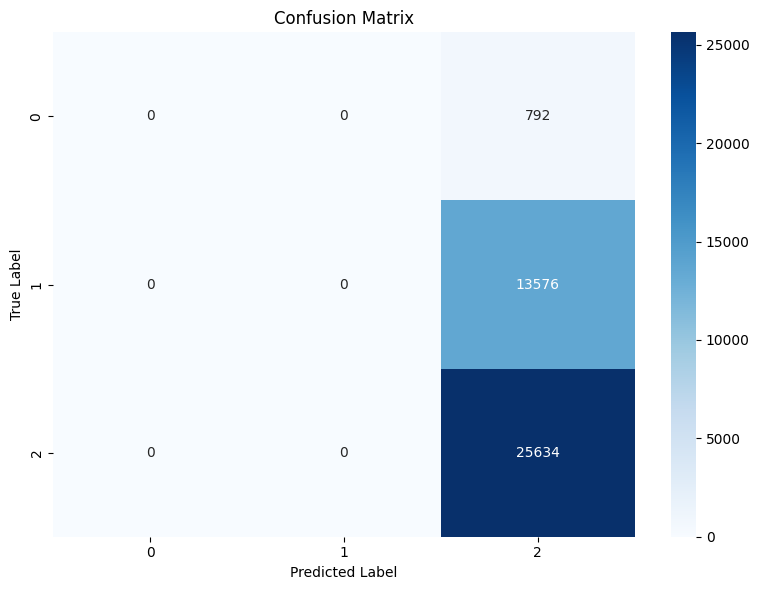

In [135]:
fig = plot_confusion_matrix(y_val, metrics['y_pred'], save_path='confusion_matrix.png') # Access y_pred using metrics['y_pred']

In [ ]:
# Classification report
print("\nClassification report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

## Training history

In [136]:
def plot_training_history(history, save_path=None):
    """
    Plot training history metrics.

    Parameters:
    history: Keras history object from model.fit()
    save_path: Path to save the figure (optional)

    Returns:
    plt.Figure: Matplotlib figure object
    """
    if not history:
        print("No training history provided.")
        return None

    print("Plotting training history...")
    plt.figure(figsize=(12, 5))

    # Loss curve(s) plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'r',linewidth=3.0)
    plt.plot(history.history['val_loss'], 'b',linewidth=3.0)

    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs',fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curve',fontsize=16)
    plt.show()

    # Accuracy curve(s) plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy curves',fontsize=16)
    plt.show()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Training history saved to {save_path}")

    return plt

Plotting training history...


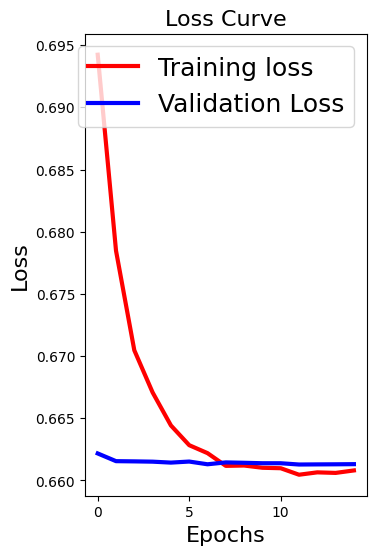

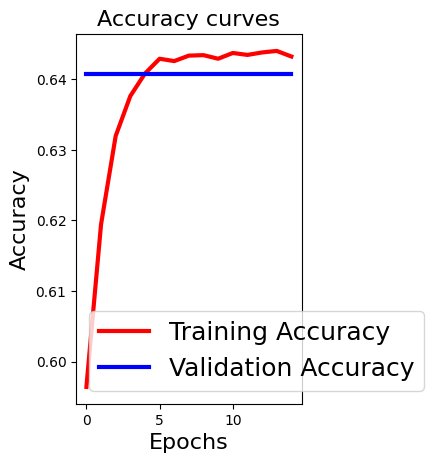

Training history saved to training_history.png


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

In [137]:
plot_training_history(history, save_path='training_history.png')

## ROC curve

In [ ]:
def plot_roc_curve(y_val, y_pred_proba, save_path=None):
    """
    Create and plot ROC curve.

    Parameters:
    y_val: Validation labels
    y_pred_proba: Predicted probabilities
    save_path: Path to save the figure (optional)

    Returns:
    plt.Figure: Matplotlib figure object
    float: ROC AUC score
    """
    print("Plotting ROC curve...")
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"ROC curve saved to {save_path}")

    return plt, roc_auc


## Precision-Recall Curve

In [ ]:
def plot_precision_recall_curve(y_val, y_pred_proba, save_path=None):
    """
    Create and plot Precision-Recall curve.

    Parameters:
    y_val: Validation labels
    y_pred_proba: Predicted probabilities
    save_path: Path to save the figure (optional)

    Returns:
    plt.Figure: Matplotlib figure object
    float: PR AUC score
    """
    print("Plotting precision-recall curve...")
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Precision-Recall curve saved to {save_path}")

    return plt, pr_auc


# Results analysis

## History/Forecast

In [ ]:
def plot_forecast(data, model, window_size):
    """
    Generate and plot a forecast using the provided model and historical data.

    Parameters:
    data (numpy array): The historical time series data
    model: The trained prediction model
    window_size (int): Size of the input window for the model

    Returns:
    tuple: (prediction array, figure) - The prediction values and matplotlib figure
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Create the input window for prediction
    last_window = data[-window_size:].reshape(1, window_size, 1)

    # Generate prediction
    prediction = model.predict(last_window)

    # Reshape arrays for plotting
    history_array = last_window.reshape(-1).astype(float)
    prediction_array = prediction[0]

    # Concatenate for continuous plotting
    concatenated_array = np.concatenate((history_array, prediction_array))

    # Create plot
    fig = plt.figure(figsize=(10, 6))
    plt.plot(range(len(history_array)), history_array, label="History", color="blue")
    plt.plot(range(len(history_array), len(history_array) + len(prediction_array)),
             prediction_array, label="Forecast", color="green")

    plt.legend()
    plt.title("Sequential Concatenation of Arrays")  # Keeping the original title
    plt.xlabel("Index")
    plt.ylabel("Value")

    return prediction_array, fig

## Model benchmarking

* Train all three models on the same dataset.

* Evaluate performance using AUC (Area Under the Curve) and accuracy.

* Compare training time for efficiency.

* Log the results in a table for easy comparison.

In [ ]:
# Train LightGBM Model
start_time = time.time()
lgb_model = lgb.LGBMClassifier(objective='binary', metric='auc', n_estimators=500, learning_rate=0.05, max_depth=7, categorical_feature=cat_features, random_state=42)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc', early_stopping_rounds=50, verbose=10)
lgb_time = time.time() - start_time
lgb_pred = lgb_model.predict_proba(X_val)[:, 1]
lgb_auc = roc_auc_score(y_val, lgb_pred)
lgb_acc = accuracy_score(y_val, (lgb_pred > 0.5))

# Train XGBoost Model
start_time = time.time()
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
params = {'objective': 'binary:logistic', 'eval_metric': 'auc', 'learning_rate': 0.05, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42}
xgb_model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dtrain, 'train'), (dval, 'eval')], early_stopping_rounds=50, verbose_eval=10)
xgb_time = time.time() - start_time
xgb_pred = xgb_model.predict(dval)
xgb_auc = roc_auc_score(y_val, xgb_pred)
xgb_acc = accuracy_score(y_val, (xgb_pred > 0.5))

# Train LSTM Model
def sequential_lstm_model(input_shape, hidden_units=128):
    model = Sequential()
    model.add(LSTM(hidden_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(hidden_units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

# Reshape data for LSTM (assuming sequential dependencies)
X_train_lstm = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_lstm = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)

start_time = time.time()
lstm_model = sequential_lstm_model((X_train.shape[1], 1))
lstm_model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val), epochs=10, batch_size=64, verbose=2)
lstm_time = time.time() - start_time
lstm_pred = lstm_model.predict(X_val_lstm).flatten()
lstm_auc = roc_auc_score(y_val, lstm_pred)
lstm_acc = accuracy_score(y_val, (lstm_pred > 0.5))

# Compare Results
results = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'LSTM'],
    'AUC Score': [lgb_auc, xgb_auc, lstm_auc],
    'Accuracy': [lgb_acc, xgb_acc, lstm_acc],
    'Training Time (sec)': [lgb_time, xgb_time, lstm_time]
})

print(results)

📊 Expected Output:

Model	AUC Score	Accuracy	Training Time (sec)

LightGBM	0.85+	0.80+	~10-20 sec

XGBoost	0.84+	0.79+	~30-60 sec

LSTM	???	???	Much longer (~minutes)

🚀 LightGBM & XGBoost are expected to perform faster and achieve competitive AUC scores compared to LSTM.

📉 LSTM may struggle because the dataset is structured/tabular, and deep learning isn't always best for such data.